# Sales Forecasting & Optimization
<div style = "text-align: center;">
   <img src="https://www.thestreet.com/.image/ar_4:3%2Cc_fill%2Ccs_srgb%2Cq_auto:good%2Cw_1200/MTkwMTAyMjA3OTUyMDcwMzAy/retail-sales.png" width ="" />
</div>

#### 🛍️ What Are Retail Sales?

Retail sales refer to the purchases made by consumers from businesses that sell goods or services directly to the public. These sales represent the final step in the distribution chain and include both in-store and online transactions.
🔑 Key Features of Retail Sales:

   - Direct to Consumer: Products are sold directly to the end user.

   - Transactional: Each sale is recorded as a financial transaction.

   - Influenced by Factors: Promotions, seasonality, holidays, store location, and customer preferences all impact retail sales.

   - Used in Analysis: Retail sales data is commonly used for:

       - Sales forecasting

       - Inventory management

       - Marketing and promotional strategy

       - Economic indicators (national retail sales can show how strong the economy is)

Examples: Supermarkets, clothing stores, electronic shops, drugstores like Rossmann, and e-commerce platforms like Amazon.

   ----------------------------------------------------------------------------------------

#### 🏪 What is the Rossmann Store Sales Dataset?

The Rossmann Store Sales dataset is a popular dataset from a Kaggle competition that focuses on time series forecasting in the retail domain. It includes historical sales data from over 1,000 Rossmann stores in Germany.
##### 📦 What the Dataset Contains:

   - Sales data: Daily revenue generated by each store.

   - Store metadata: Includes information like store type, assortment type, competition distance, etc.

   - Promotions: Whether a store was running a promotion on a given day.

   - External factors:

       - Public holidays

       - School holidays

       - Competitor activity

       - Store closures

##### 📅 Time Span:

   - Data ranges from 2013 to 2015.

🔍 Why is This Dataset Valuable?

   - It's ideal for time series forecasting (predicting future sales).

   - Great for learning how store-level and external factors influence sales.

   - Used to train machine learning models like XGBoost, Random Forest, LSTMs, etc.

   - Helps in decision-making for inventory stocking, staffing, and marketing efforts.

📊 Common Use Cases for This Dataset:

   - Predicting daily sales for each store.

   - Evaluating the impact of promotions and holidays on sales.

   - Identifying which store features are most predictive of high performance.

#### 📁 train.csv

##### This is the main training dataset used to train your model.
It contains:

   - Store: unique store ID

   - Date: the date of the sale

   - Sales: the amount of revenue for that day (target variable!)

   - Customers: number of customers that day

   - Open: whether the store was open (1 = open, 0 = closed)

   - Promo: whether the store was running a promotion

   - StateHoliday: indicates a public holiday

   - SchoolHoliday: indicates whether the day was a school holiday

#### 📁 test.csv

##### This file contains data points for which you need to predict sales (no sales column is present).
##### Similar to train.csv except:

   - It does not include the Sales column (your model should predict this).

   - Used for generating the final submission.

#### 📁 store.csv

##### This file contains additional metadata about each store.
For each Store ID, it includes:

   - StoreType: differentiates between store models (e.g., a, b, c, d)

   - Assortment: level of product assortment (basic = a, extended = b, extra = c)

   - CompetitionDistance: distance to the nearest competitor

   - CompetitionOpenSince[Month/Year]: when nearby competition opened

   - Promo2: whether the store is running a continuous promotion

   - Promo2SinceWeek/Year: start date of continuous promotion

   - PromoInterval: months in which promo2 is active

##### 🔁 You'll join store.csv with train.csv and test.csv on the Store column to enrich the training and prediction features.
#### 📁 sample_submission.csv

This is a template showing the format of the final submission.
Contains:

   - Id: from test.csv

   - Sales: your model's predicted value

You’ll fill in the Sales column using your predictions and submit it to Kaggle.

# Importing important libraries

In [2]:
!pip install prophet

In [2]:
import os
import warnings

# loading packages
# basic + dates 
import numpy as np
import pandas as pd
from datetime import datetime

# Data visualization
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Statistics
from statsmodels.distributions.empirical_distribution import ECDF

# Time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# prophet by Facebook
from prophet import Prophet

In [3]:
warnings.filterwarnings("ignore")
pd.set_option("display.max_rows",None)
matplotlib.style.use("ggplot")

In [5]:
# importing train data to train_data
train_data = pd.read_csv("/kaggle/input/rossman-stores-sales/train.csv", 
                        parse_dates=True, low_memory=False, index_col='Date')

# importing test data to test_data
test_data = pd.read_csv("/kaggle/input/rossman-stores-sales/test.csv")

# importing store data to store_data
store_data = pd.read_csv("/kaggle/input/rossman-stores-sales/store.csv",
                        low_memory=False)

##### ⏳ parse_dates=True

   - Automatically tries to parse any column that looks like a date (like Date) into a proper datetime object.

   - This helps with time series operations like sorting, resampling, and plotting.

##### 📉 low_memory=False

   - Tells pandas to read the file in one go, instead of chunking it.

   - Why? Sometimes pandas reads large files in chunks to save memory, which can lead to mixed data types. Setting low_memory=False ensures type consistency but uses more RAM.

##### 📅 index_col='Date'

   - Sets the Date column as the index of the DataFrame.

   - This is especially useful for time series analysis where dates become your primary axis for filtering, resampling, and plotting.

In [6]:
# Time series index
train_data.index

DatetimeIndex(['2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31',
               ...
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01'],
              dtype='datetime64[ns]', name='Date', length=1017209, freq=None)

In [7]:
print('Input total shape: ',train_data.shape)
train_data.head()

Input total shape:  (1017209, 8)


Store  DayOfWeek  Sales  Customers  Open  Promo StateHoliday  \
Date                                                                       
2015-07-31      1          5   5263        555     1      1            0   
2015-07-31      2          5   6064        625     1      1            0   
2015-07-31      3          5   8314        821     1      1            0   
2015-07-31      4          5  13995       1498     1      1            0   
2015-07-31      5          5   4822        559     1      1            0   

            SchoolHoliday  
Date                       
2015-07-31              1  
2015-07-31              1  
2015-07-31              1  
2015-07-31              1  
2015-07-31              1

In [8]:
test_data.head(2)

Id  Store  DayOfWeek        Date  Open  Promo StateHoliday  SchoolHoliday
0   1      1          4  2015-09-17   1.0      1            0              0
1   2      3          4  2015-09-17   1.0      1            0              0

#### test data is same as train data but with sales column removed.

In [9]:
store_data.head(2)

Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
0      1         c          a               1270.0                        9.0   
1      2         a          a                570.0                       11.0   

   CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
0                    2008.0       0              NaN              NaN   
1                    2007.0       1             13.0           2010.0   

     PromoInterval  
0              NaN  
1  Jan,Apr,Jul,Oct

# **Milestone 1: Data Collection, Exploration, and Preprocessing**

# Exploratory Data Analysis

## - First we will start analysis on train data which is same as test data.

In [10]:
train_data.head(2)

Store  DayOfWeek  Sales  Customers  Open  Promo StateHoliday  \
Date                                                                       
2015-07-31      1          5   5263        555     1      1            0   
2015-07-31      2          5   6064        625     1      1            0   

            SchoolHoliday  
Date                       
2015-07-31              1  
2015-07-31              1

#### train.csv short description

   - Store: unique store ID

   - Date: the date of the sale

   - Sales: the amount of revenue for that day (target variable!)

   - Customers: number of customers that day

   - Open: whether the store was open (1 = open, 0 = closed)

   - Promo: whether the store was running a promotion

   - StateHoliday: indicates a public holiday

   - SchoolHoliday: indicates whether the day was a school holiday

In [11]:
# summary of train(or test) data structure
train_data.info()    

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1017209 entries, 2015-07-31 to 2013-01-01
Data columns (total 8 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Sales          1017209 non-null  int64 
 3   Customers      1017209 non-null  int64 
 4   Open           1017209 non-null  int64 
 5   Promo          1017209 non-null  int64 
 6   StateHoliday   1017209 non-null  object
 7   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 69.8+ MB


#### observation:
- All train data features has no missing values.
- All features data types are numeric except **'StateHoliday'** has object data type.

We are dealing with time series data so it will probably serve us to extract dates for further analysis. We also have two likely correlated vaiables in the dataset, which can be combined into a new feature.


In [12]:
# data extraction > creating 4 new variables(columns) from data column which is index of that dataframe.
train_data['Year'] = train_data.index.year
train_data['Month'] = train_data.index.month
train_data['Day'] = train_data.index.day
train_data['WeekofYear'] = train_data.index.isocalendar().week

# adding new variable(column)
train_data['SalesPerCustomer'] = train_data['Sales']/train_data['Customers']

In [13]:
# new variable(SalesPerCustomer) general statistics
train_data.SalesPerCustomer.describe()

count    844340.000000
mean          9.493619
std           2.197494
min           0.000000
25%           7.895563
50%           9.250000
75%          10.899729
max          64.957854
Name: SalesPerCustomer, dtype: float64

On average customers spend about 9.50$ per day. Though there are days with Sales equal to zero.


ECDF: Empirical Cumulative Distribution Function

To get the first impression about continious variables in the data we can plot ECDF.


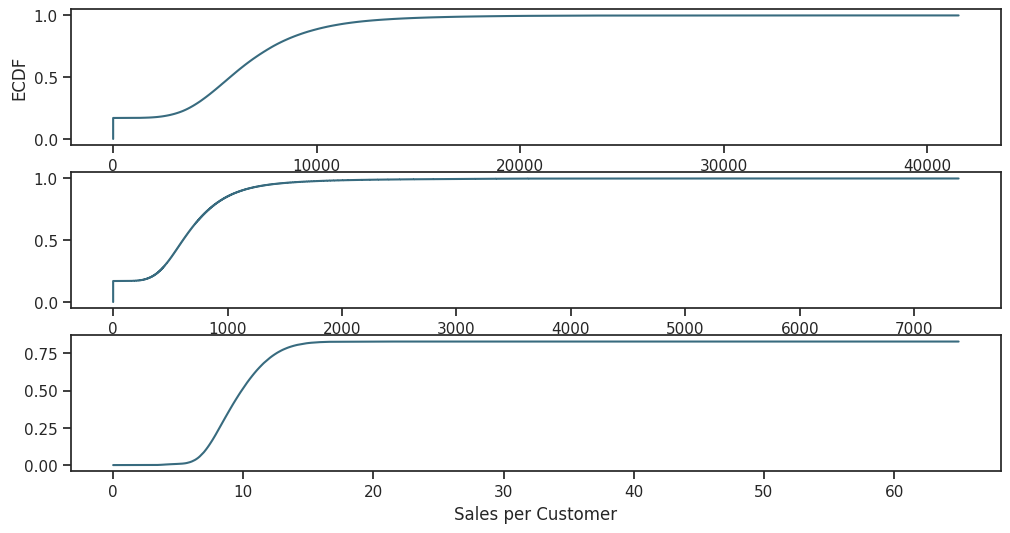

In [14]:
sns.set(style = "ticks")# to format into seaborn 
c = '#386B7F' # basic color for plots
plt.figure(figsize = (12, 6))

# plot First ECDF
plt.subplot(311)
cdf = ECDF(train_data['Sales'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Sales'); plt.ylabel('ECDF');

# plot second ECDF
plt.subplot(312)
cdf = ECDF(train_data['Customers'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Customers');


# plot third ECDF  
plt.subplot(313)
cdf = ECDF(train_data['SalesPerCustomer'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Sales per Customer');
plt.show()

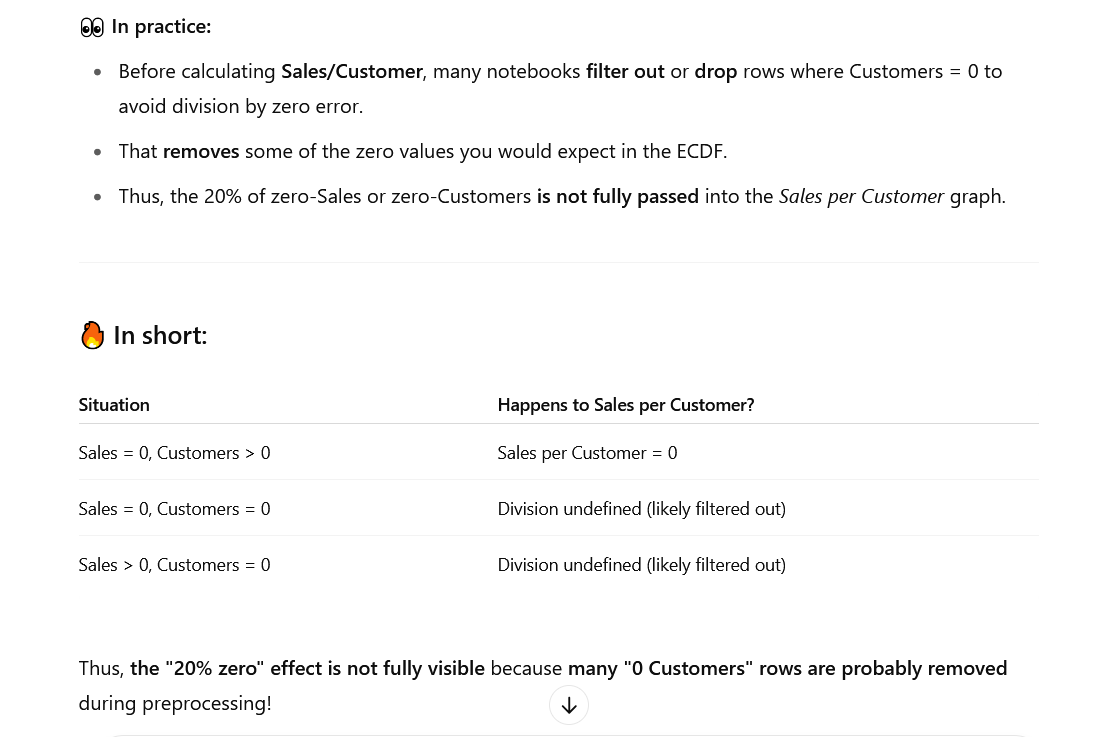
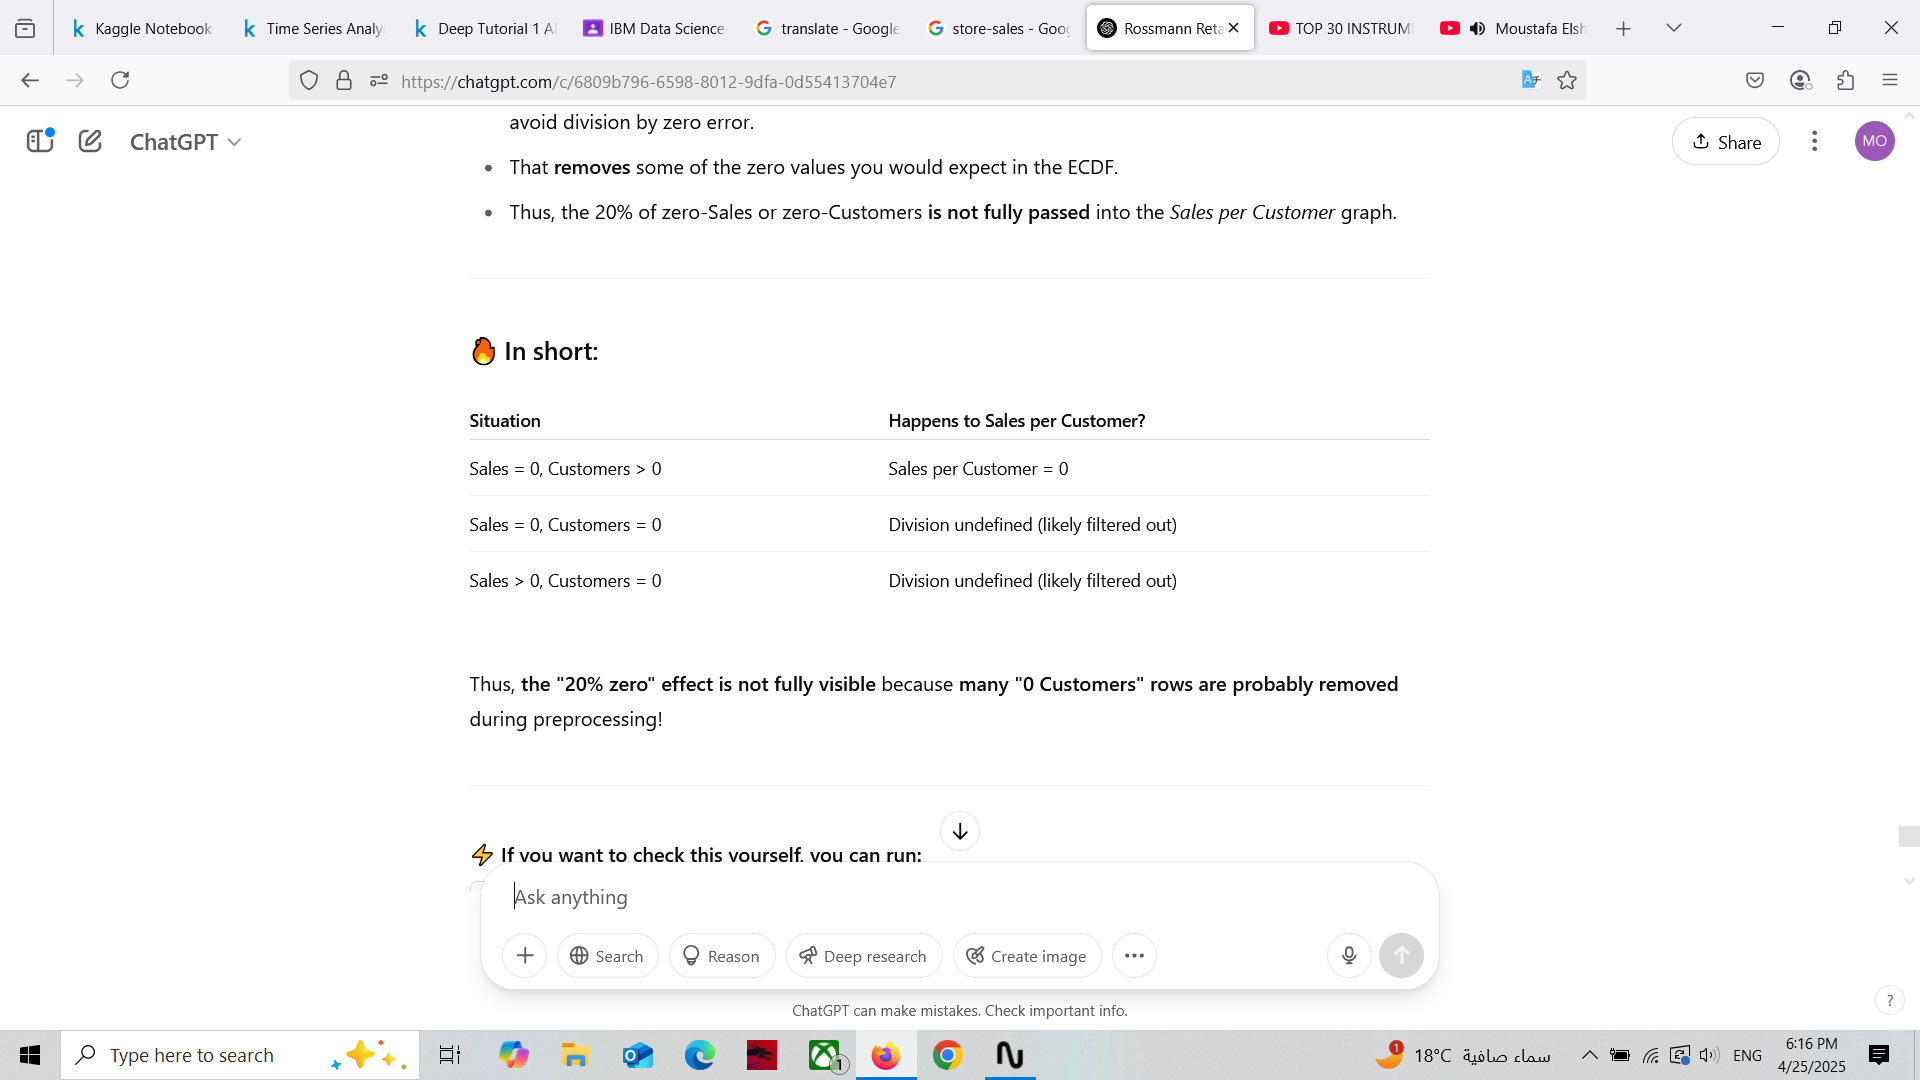

About 20% of data has zero amount of sales / customers that we need to deal with and almost 80% of time daily amount of sales was less than 1000. So what about zero sales, is it only due to the fact that the store is closed?

Missing values

Closed stores and zero sales stores

In [15]:
train_data[(train_data.Open == 0) & (train_data.Sales == 0)].head()

Store  DayOfWeek  Sales  Customers  Open  Promo StateHoliday  \
Date                                                                       
2015-07-31    292          5      0          0     0      1            0   
2015-07-31    876          5      0          0     0      1            0   
2015-07-30    292          4      0          0     0      1            0   
2015-07-30    876          4      0          0     0      1            0   
2015-07-29    292          3      0          0     0      1            0   

            SchoolHoliday  Year  Month  Day  WeekofYear  SalesPerCustomer  
Date                                                                       
2015-07-31              1  2015      7   31          31               NaN  
2015-07-31              1  2015      7   31          31               NaN  
2015-07-30              1  2015      7   30          31               NaN  
2015-07-30              1  2015      7   30          31               NaN  
2015-07-29              1  2015      7   29          31               NaN

In [16]:
train_data[(train_data.Open == 0) & (train_data.Sales == 0)]['Sales'].value_counts().sum()

172817



There're 172817 closed stores in the data. It is about 10% of the total amount of observations. To avoid any biased forecasts we will drop these values.

What about opened stores with zero sales?

In [17]:
# opened stores with zero sales
zero_sales = train_data[(train_data.Open != 0) & (train_data.Sales == 0)]
print("In total: ", zero_sales.shape)
zero_sales.head(5)



In total:  (54, 13)


Store  DayOfWeek  Sales  Customers  Open  Promo StateHoliday  \
Date                                                                       
2015-05-15    971          5      0          0     1      0            0   
2015-03-26    674          4      0          0     1      0            0   
2015-02-05    699          4      0          0     1      1            0   
2014-10-01    708          3      0          0     1      1            0   
2014-09-22    357          1      0          0     1      0            0   

            SchoolHoliday  Year  Month  Day  WeekofYear  SalesPerCustomer  
Date                                                                       
2015-05-15              1  2015      5   15          20               NaN  
2015-03-26              0  2015      3   26          13               NaN  
2015-02-05              0  2015      2    5           6               NaN  
2014-10-01              0  2014     10    1          40               NaN  
2014-09-22              0  2014      9   22          39               NaN

In [18]:
train_data[(train_data.Open == 1) & (train_data.Sales == 0)]['Sales'].value_counts().sum()

54



Interestingly enough, there are opened store with no sales on working days. There're only 54 days in the data, so we can assume that there were external factors involved, for example manifestations.


In [19]:
print("Closed stores and days which didn't have any sales won't be counted into the forecasts.")
train_data = train_data[(train_data["Open"] != 0) & (train_data['Sales'] != 0)]

print("In total: ", train_data.shape)

Closed stores and days which didn't have any sales won't be counted into the forecasts.
In total:  (844338, 13)


## - Analysis on store data.

In [20]:
store_data.head(2)

Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
0      1         c          a               1270.0                        9.0   
1      2         a          a                570.0                       11.0   

   CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
0                    2008.0       0              NaN              NaN   
1                    2007.0       1             13.0           2010.0   

     PromoInterval  
0              NaN  
1  Jan,Apr,Jul,Oct

#### store.csv short description

#### - StoreType:

Type or model of the store (e.g., 'a', 'b', 'c', 'd'). Different types might have different sizes, styles, or sales strategies.

#### - Assortment:

How many types of products the store carries:
• a = basic
• b = extended
• c = extra wide variety

#### - CompetitionDistance:


How far (in meters) the closest competitor's store is from this store. A smaller number = closer - competitor.

#### - CompetitionOpenSinceMonth/Year:


When the nearest competing store opened. Important because it might affect sales after that date.


#### - Promo2:

 
Whether this store is participating in an ongoing promotion (like loyalty programs).
  • 1 = yes
  • 0 = no

  
#### - Promo2SinceWeek/Year:


In which week/year the Promo2 started for this store. (So you can model effects of promotions starting.)

#### - PromoInterval:

Which months the Promo2 is active. Example: "Feb,May,Aug,Nov" means the store has special promotions in February, May, August, and November.


In [21]:
# summary of store data structure 
store_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


#### observation:
 Many features has missing values as:
 
    - CompetitionDistance       >>  3 
    - CompetitionOpenSinceMonth >> 354 
    - CompetitionOpenSinceMonth >> 354
    - Promo2SinceWeek           >> 544
    - Promo2SinceYear           >> 544
    - PromoInterval             >> 544
      
  so there are columns has same number of missing values so they could be related.

In [22]:
store_data.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64



We have few variables with missing values that we need to deal with. Let's start with the CompetitionDistance.


In [23]:
# missing values in CompetitionDistance
store_data[pd.isnull(store_data.CompetitionDistance)]

Store StoreType Assortment  CompetitionDistance  \
290    291         d          a                  NaN   
621    622         a          c                  NaN   
878    879         d          a                  NaN   

     CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
290                        NaN                       NaN       0   
621                        NaN                       NaN       0   
878                        NaN                       NaN       1   

     Promo2SinceWeek  Promo2SinceYear    PromoInterval  
290              NaN              NaN              NaN  
621              NaN              NaN              NaN  
878              5.0           2013.0  Feb,May,Aug,Nov



Apperently this information is simply missing from the data. No particular pattern observed. In this case, it makes a complete sense to replace NaN with the median values (which is twice less that the average).


In [24]:
# fill NaN with a median value (skewed distribuion)
store_data['CompetitionDistance'].fillna(store_data['CompetitionDistance'].median(), inplace=True)



Continuing further with missing data. What about Promo2SinceWeek & CompetitionOpenSince[Month/Year]?

May it be that we observe unsusual data points?


In [25]:
# no promo = no information about the promo?
_ = store_data[pd.isnull(store_data.Promo2SinceWeek)]
_[_.Promo2 != 0].shape

(0, 10)



No, if there's no Promo2 then there's no information about it. We can replace these values by zeros. The same goes for the variables deducted from the competition, CompetitionOpenSinceMonth and CompetitionOpenSinceYear.


In [26]:
# replace NA's by 0
store_data.fillna(0, inplace = True)

## - Analysis on train data & store data (Concatenate them).

In [27]:
print("Joining train set with an additional store information.")

# by specifying inner join we make sure that only those observations 
# that are present in both train and store sets are merged together
train_store = pd.merge(train_data, store_data, how = 'inner', on = 'Store')

print("In total: ", train_store.shape)
train_store.head()

Joining train set with an additional store information.
In total:  (844338, 22)


Store  DayOfWeek  Sales  Customers  Open  Promo StateHoliday  \
0      1          5   5263        555     1      1            0   
1      2          5   6064        625     1      1            0   
2      3          5   8314        821     1      1            0   
3      4          5  13995       1498     1      1            0   
4      5          5   4822        559     1      1            0   

   SchoolHoliday  Year  Month  ...  SalesPerCustomer  StoreType  Assortment  \
0              1  2015      7  ...          9.482883          c           a   
1              1  2015      7  ...          9.702400          a           a   
2              1  2015      7  ...         10.126675          a           a   
3              1  2015      7  ...          9.342457          c           c   
4              1  2015      7  ...          8.626118          a           a   

  CompetitionDistance CompetitionOpenSinceMonth  CompetitionOpenSinceYear  \
0              1270.0                       9.0                    2008.0   
1               570.0                      11.0                    2007.0   
2             14130.0                      12.0                    2006.0   
3               620.0                       9.0                    2009.0   
4             29910.0                       4.0                    2015.0   

   Promo2  Promo2SinceWeek  Promo2SinceYear    PromoInterval  
0       0              0.0              0.0                0  
1       1             13.0           2010.0  Jan,Apr,Jul,Oct  
2       1             14.0           2011.0  Jan,Apr,Jul,Oct  
3       0              0.0              0.0                0  
4       0              0.0              0.0                0  

[5 rows x 22 columns]


Store types

In this section we will closely look at different levels of StoreType and how the main metric Sales is distributed among them.


In [28]:
train_store['StoreType'].value_counts()

StoreType
a    457042
d    258768
c    112968
b     15560
Name: count, dtype: int64

In [29]:
train_store.groupby('StoreType')['Sales'].count().to_frame('Sale records exist').sort_values(by='Sale records exist',ascending=False)

Sale records exist
StoreType                    
a                      457042
d                      258768
c                      112968
b                       15560

Counts how many sales records exist for each store type (not the total sales amount, just the number of rows)

In [30]:
train_store.groupby('StoreType')['Sales'].describe()

count          mean          std     min      25%     50%  \
StoreType                                                                 
a          457042.0   6925.697986  3277.351589    46.0  4695.25  6285.0   
b           15560.0  10233.380141  5155.729868  1252.0  6345.75  9130.0   
c          112968.0   6933.126425  2896.958579   133.0  4916.00  6408.0   
d          258768.0   6822.300064  2556.401455   538.0  5050.00  6395.0   

                75%      max  
StoreType                     
a           8406.00  41551.0  
b          13184.25  38722.0  
c           8349.25  31448.0  
d           8123.25  38037.0



StoreType B has the highest average of Sales among all others, however we have much less data for it.

So let's print an overall sum of Sales and Customers to see which StoreType is the most selling and crowded one:


In [31]:
train_store.groupby('StoreType')[['Customers', 'Sales']].sum()

Customers       Sales
StoreType                       
a          363541431  3165334859
b           31465616   159231395
c           92129705   783221426
d          156904995  1765392943



Clearly stores of type A. StoreType D goes on the second place in both Sales and Customers. What about date periods? Seaborn's facet grid is the best tool for this task:


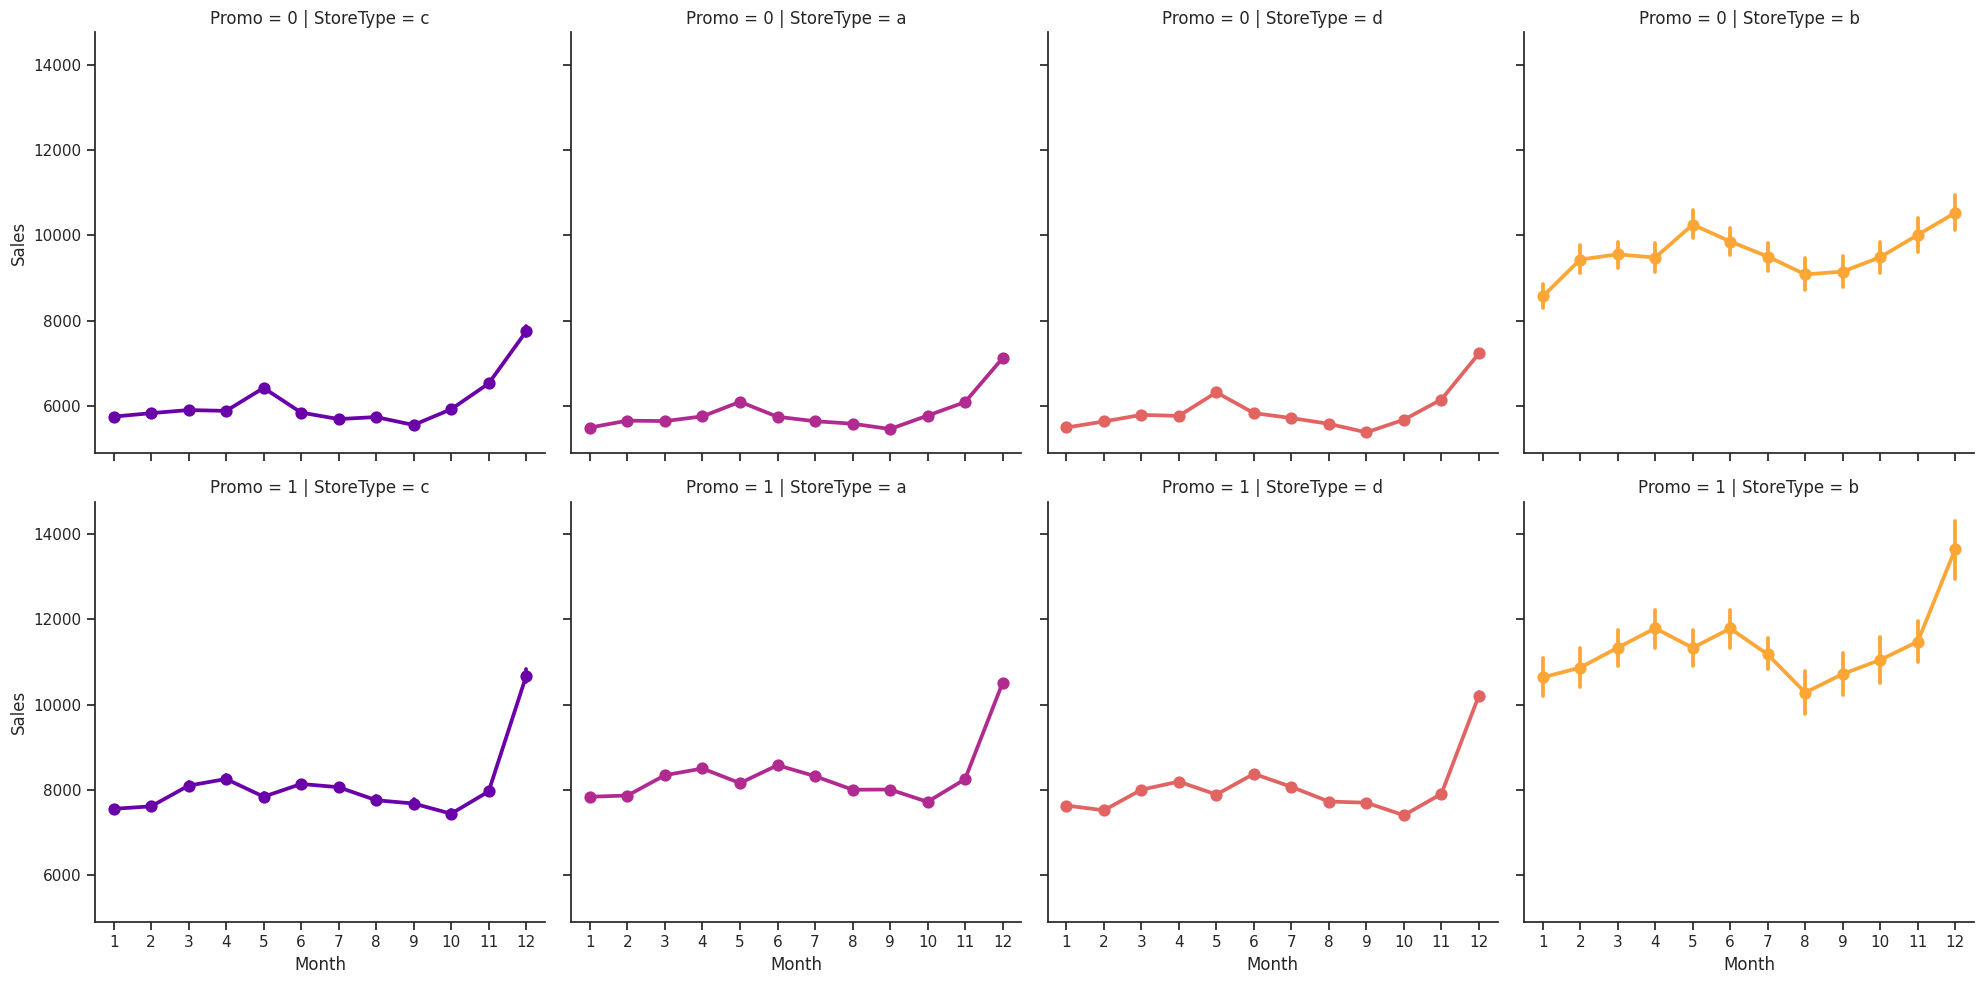

In [32]:
sns.catplot(data=train_store, x='Month', y='Sales', 
            col='StoreType',
            row = 'Promo' ,
            hue='StoreType',
            palette='plasma',
            kind='point',
           color = c)  # or 'violin', 'point', etc.

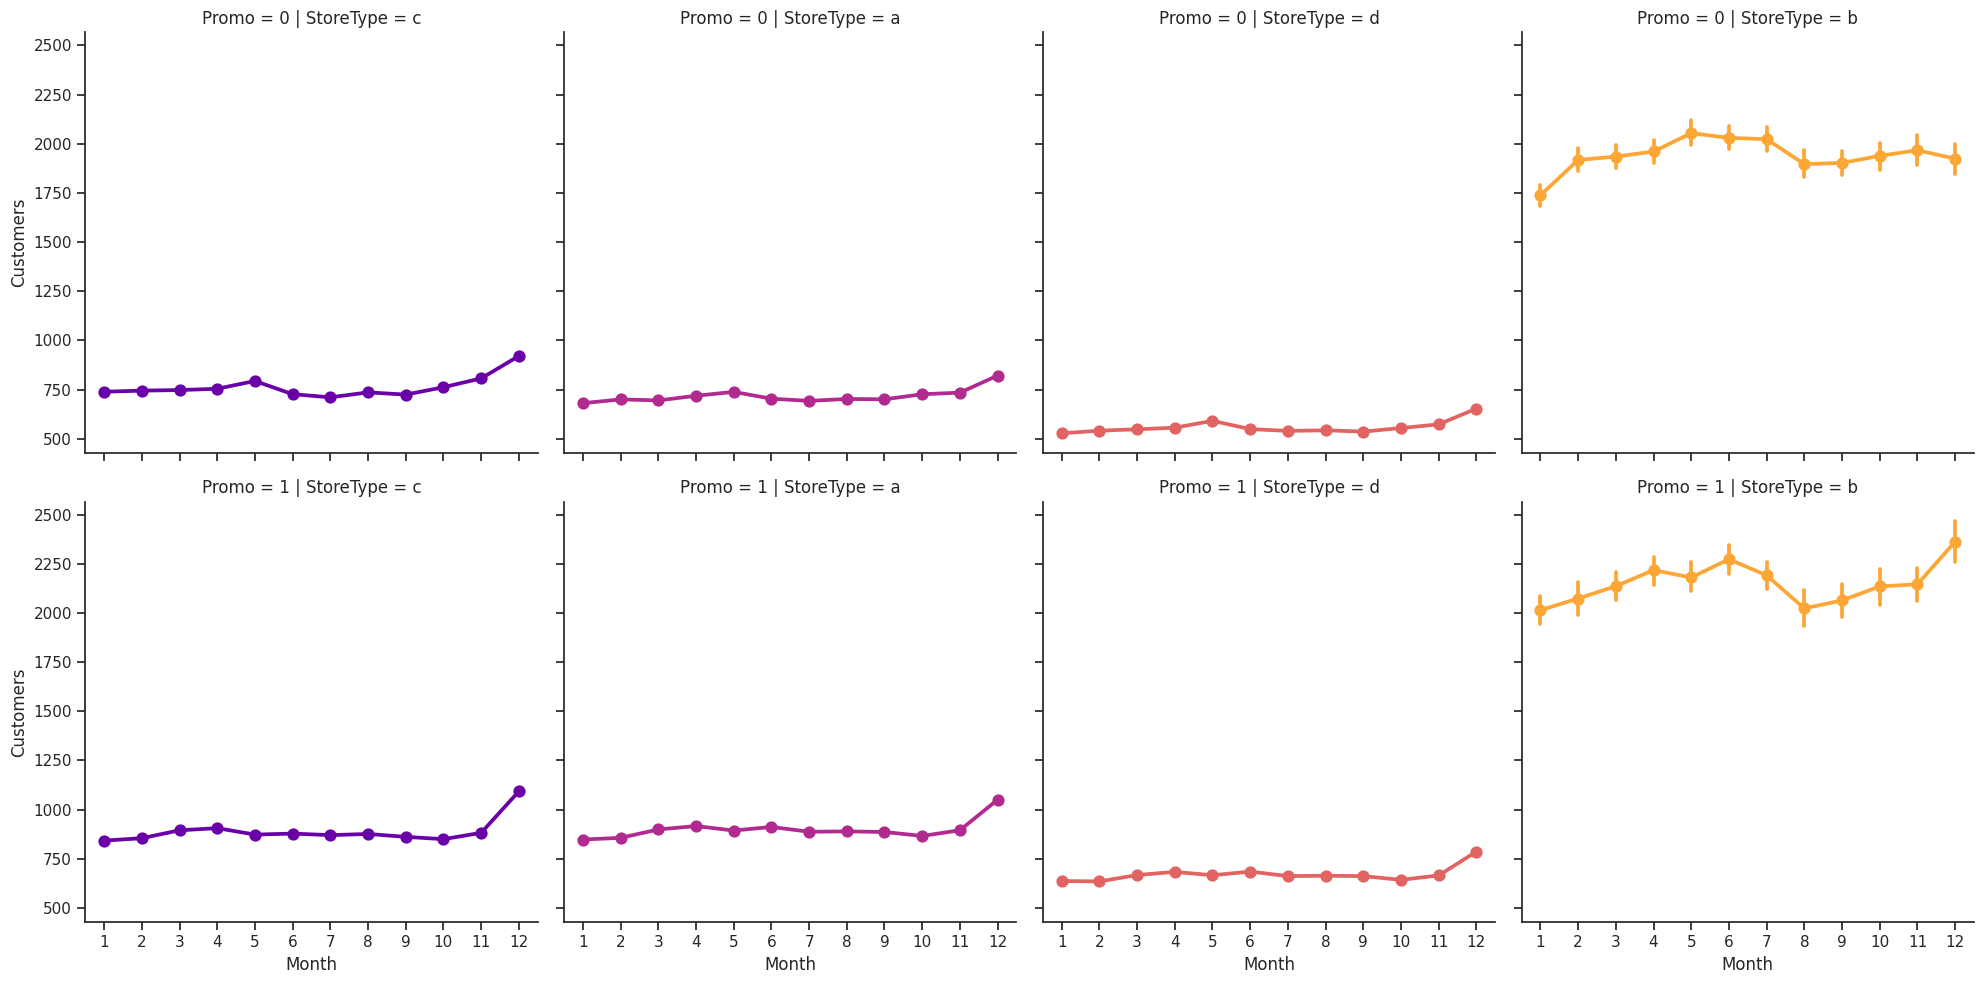

In [33]:
# sales trends
sns.catplot(data = train_store, x = 'Month', y = "Customers", 
               col = 'StoreType', # per store type in cols
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo', # per promo in the store in rows
               color = c,
               kind = 'point') 



All store types follow the same trend but at different scales depending on the presence of the (first) promotion Promo and StoreType itself (case for B).

**Already at this point, we can see that Sales escalate towards Christmas holidays. But we'll talk about seasonalities and trends later in the Time Series Analysis section.**


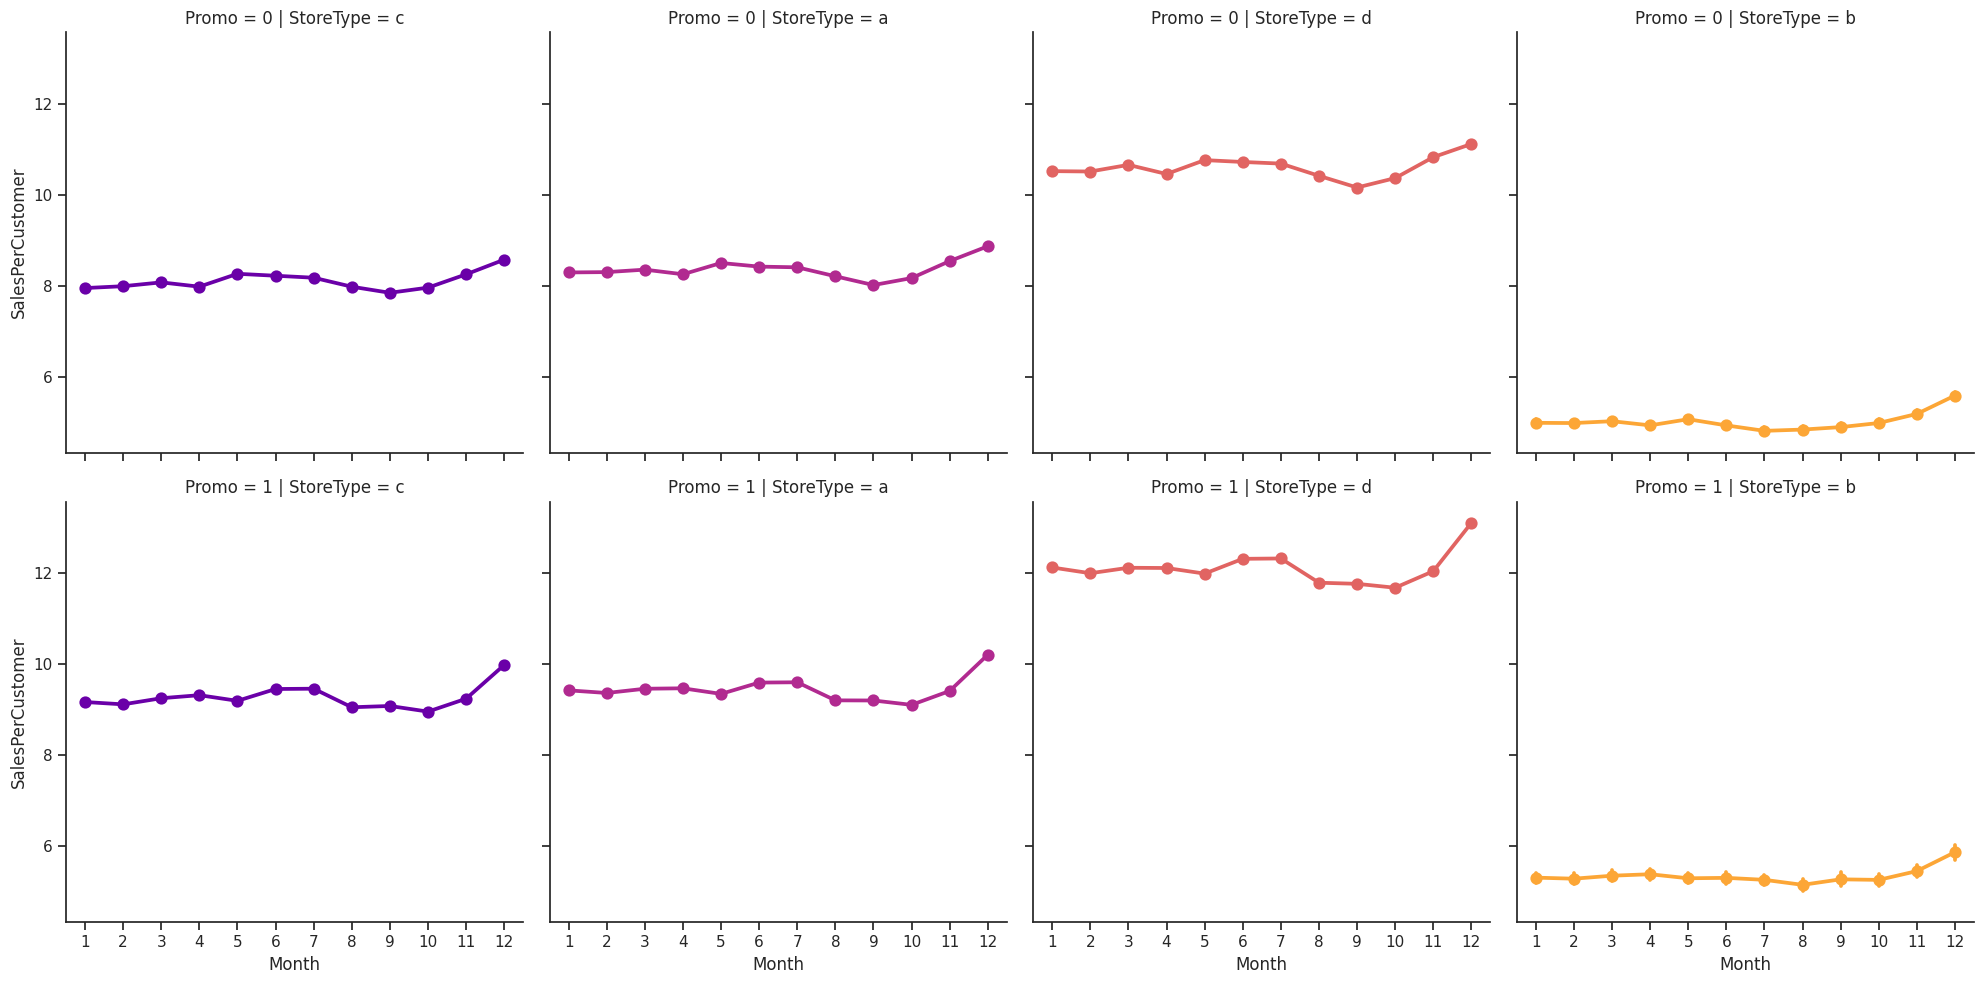

In [34]:
# sale per customer trends
sns.catplot(data = train_store, x = 'Month', y = "SalesPerCustomer", 
               col = 'StoreType', # per store type in cols
               palette = 'plasma',
               hue = 'StoreType',
               row = 'Promo', # per promo in the store in rows
               color = c ,
               kind = 'point') 



Aha! Eventhough the plots above showed StoreType B as the most selling and performant one, in reality it is not true. The highest SalePerCustomer amount is observed at the StoreType D, about 12€ with Promo and 10€ without. As for StoreType A and C it is about 9€.

Low SalePerCustomer amount for StoreType B describes its Buyer Cart: there are a lot of people who shop essentially for "small" things (or in a little quantity). Plus we saw that overall this StoreType generated the least amount of sales and customers over the period.


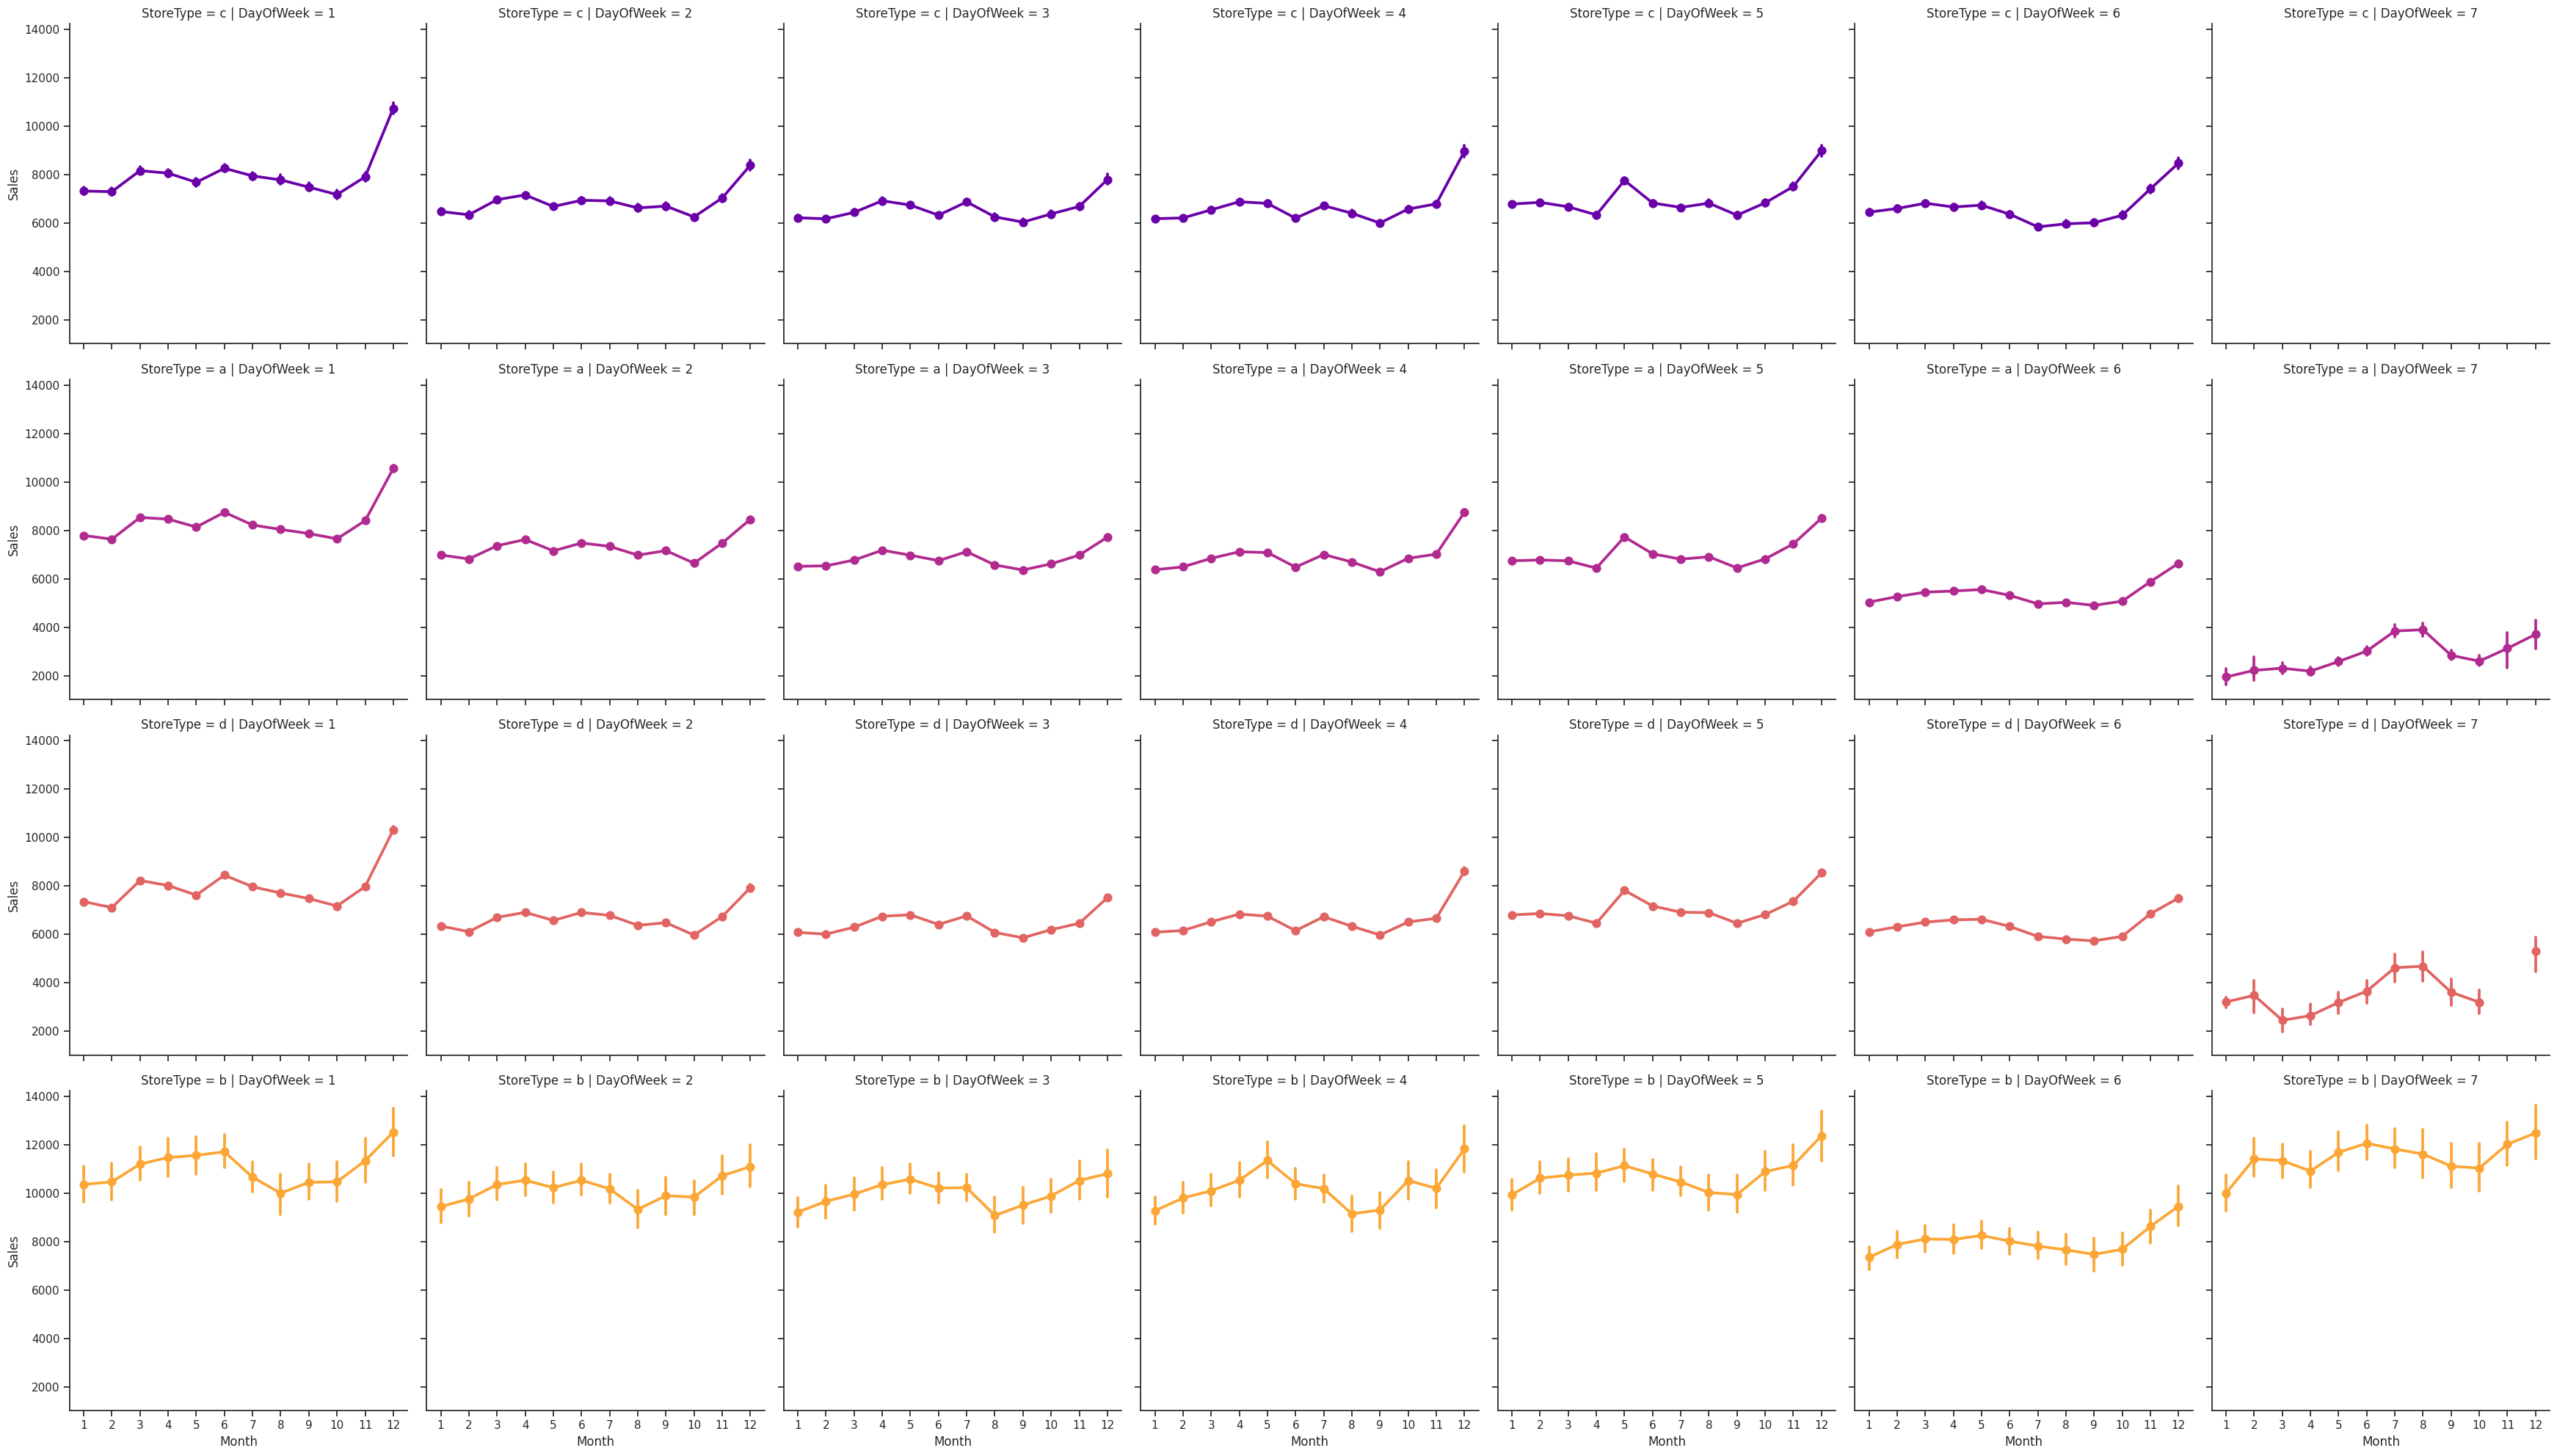

In [35]:
# customers
sns.catplot(data = train_store, x = 'Month', y = "Sales", 
               col = 'DayOfWeek', # per store type in cols
               palette = 'plasma',
               hue = 'StoreType',
               row = 'StoreType', # per store type in rows
               color = c,
               kind = 'point') 



We see that stores of StoreType C are all closed on Sundays, whereas others are most of the time opened. Interestingly enough, stores of StoreType D are closed on Sundays only from October to December.

Bt the way what are the stores which are opened on Sundays?


In [36]:
# stores which are opened on sundays
train_store[(train_store['Open']==1) & (train_store.DayOfWeek == 7)]['Store'].unique()

array([  85,  122,  209,  259,  262,  274,  299,  310,  335,  353,  423,
        433,  453,  494,  512,  524,  530,  562,  578,  676,  682,  732,
        733,  769,  863,  867,  931,  948, 1045, 1081, 1097, 1099,  877])

To complete our preliminary data analysis, we can add variables describing the period of time during which competition and promotion were opened:

In [37]:
# competition open time (in months)
train_store['CompetitionOpen'] = 12 * (train_store.Year - train_store.CompetitionOpenSinceYear) + \
        (train_store.Month - train_store.CompetitionOpenSinceMonth)
    
# Promo open time
train_store['PromoOpen'] = 12 * (train_store.Year - train_store.Promo2SinceYear) + \
        (train_store.WeekofYear - train_store.Promo2SinceWeek) / 4.0

# average PromoOpen time and CompetitionOpen time per store type
train_store.loc[:, ['StoreType', 'Sales', 'Customers', 'PromoOpen', 'CompetitionOpen']].groupby('StoreType').mean()

Sales    Customers     PromoOpen  CompetitionOpen
StoreType                                                          
a           6925.697986   795.422370  12918.492198      7115.514452
b          10233.380141  2022.211825  17199.328069     11364.495244
c           6933.126425   815.538073  12158.636107      6745.418694
d           6822.300064   606.353935  10421.916846      9028.526526



The most selling and crowded StoreType A doesn't appear to be the one the most exposed to competitors. Instead it's a StoreType B, which also has the longest running period of promotion.



Correlational Analysis

We are finished with adding new variables to the data, so now we can check the overall correlations by plotting the seaborn heatmap:


In [38]:
numerical_ = train_store.select_dtypes(exclude = ['string','object'])
numerical_.head(2)

Store  DayOfWeek  Sales  Customers  Open  Promo  SchoolHoliday  Year  \
0      1          5   5263        555     1      1              1  2015   
1      2          5   6064        625     1      1              1  2015   

   Month  Day  WeekofYear  SalesPerCustomer  CompetitionDistance  \
0      7   31          31          9.482883               1270.0   
1      7   31          31          9.702400                570.0   

   CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                        9.0                    2008.0       0   
1                       11.0                    2007.0       1   

   Promo2SinceWeek  Promo2SinceYear  CompetitionOpen  PromoOpen  
0              0.0              0.0             82.0   24187.75  
1             13.0           2010.0             92.0       64.5

In [39]:
# Compute the correlation matrix 
# exclude 'Open' variable
corr_all = numerical_.drop('Open', axis = 1).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_all, dtype = bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_all, mask = mask,
            square = True, linewidths = .5, ax = ax, cmap = "BuPu")      
plt.show()



As mentioned before, we have a strong positive correlation between the amount of Sales and Customers of a store. We can also observe a positive correlation between the fact that the store had a running promotion (Promo equal to 1) and amount of Customers.

However, as soon as the store continues a consecutive promotion (Promo2 equal to 1) the number of Customers and Sales seems to stay the same or even decrease, which is described by the pale negative correlation on the heatmap. The same negative correlation is observed between the presence of the promotion in the store and the day of a week.


In [40]:
# sale per customer trends
sns.catplot(data = train_store, x = 'DayOfWeek', y = "Sales", 
               col = 'Promo', 
               row = 'Promo2',
               hue = 'Promo2',
               palette = 'RdPu',
              kind = 'point') 


There are several things here:

   - In case of no promotion, both Promo and Promo2 are equal to 0, Sales tend to peak on Sunday (!). Though we should note that StoreType C doesn't work on Sundays. So it is mainly data from StoreType A, B and D.
   - On the contrary, stores that run the promotion tend to make most of the Sales on Monday. This fact could be a good indicator for Rossmann marketing campaigns. The same trend follow the stores which have both promotion at the same time (Promo and Promo2 are equal to 1).
   - Promo2 alone doesn't seem to be correlated to any significant change in the Sales amount. This can be also prooved by the blue pale area on the heatmap above.

---------------------------------------------------------------------------------------------------------------------------------------------------


Conclusion of EDA

   - The most selling and crowded StoreType is A.

   - The best "Sale per Customer" StoreType D indicates to the higher Buyer Cart. To benefit from this fact, Rossmann can consider proposing bigger variety of its products.

   - Low SalePerCustomer amount for StoreType B indicates to the possible fact that people shop there essentially for "small" things. Eventhough this StoreType generated the least amount of sales and customers over the whole period, it shows a great potential.

   - Customers tends to buy more on Modays when there's one promotion (Promo) and on Sundays when there's no promotion at all (both Promo and Promo1 are equal to 0).

   - Promo2 alone doesn't seem to be correlated to any significant change in the Sales amount.

# Time-Series Analysis per Store Type



What makes a time series different from a regular regression problem?

   - It is time dependent. The basic assumption of a linear regression that the observations are independent doesn’t hold in this case.
   - Along with an increasing or decreasing trend, most time series have some form of seasonality trends, i.e. variations specific to a particular time frame. For example, for Christmas holidays, which we will see in this dataset.

We build a time series analysis on store types instead of individual stores. The main advantage of this approach is its simplicity of presentation and overall account for different trends and seasonalities in the dataset.

In this section, we will analyse time series data: its trends, sesonalities and autocorrelation. Usually at the end of the analysis, we are able to develop a seasonal ARIMA (Autoregression Integrated Moving Average) model but it won't be our main focus today. Instead, we try to understand the data, and only later come up with the forecasts using Prophet methodology.
Seasonality
We take four stores from store types to represent their group:

   - Store number 2 for StoreType A
   - Store number 85 for StoreType B,
   - Store number 1 for StoreType C
   - Store number 13 for StoreType D.

It also makes sense to downsample the data from days to weeks using the resample method to see the present trends more clearly.


In [41]:
# preparation: input should be float type
train_data['Sales'] = train_data['Sales'] * 1.0

# store types
sales_a = train_data[train_data.Store == 2]['Sales']
sales_b = train_data[train_data.Store == 85]['Sales'].sort_index(ascending = True) # solve the reverse order
sales_c = train_data[train_data.Store == 1]['Sales']
sales_d = train_data[train_data.Store == 13]['Sales']

f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))

# store types
sales_a.resample('W').sum().plot(color = c, ax = ax1)
sales_b.resample('W').sum().plot(color = c, ax = ax2)
sales_c.resample('W').sum().plot(color = c, ax = ax3)
sales_d.resample('W').sum().plot(color = c, ax = ax4)

<Axes: xlabel='Date'>



Retail sales for StoreType A and C tend to peak for the Christmas season and then decline after the holidays. We might have seen the same trend for StoreType D (at the bottom) but there is no information from July 2014 to January 2015 about these stores as they were closed.
Yearly trend

The next thing to check the presence of a trend in series.


In [42]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))

# monthly
decomposition_a = seasonal_decompose(sales_a, model = 'additive', period = 365)
decomposition_a.trend.plot(color = c, ax = ax1)

decomposition_b = seasonal_decompose(sales_b, model = 'additive', period = 365)
decomposition_b.trend.plot(color = c, ax = ax2)

decomposition_c = seasonal_decompose(sales_c, model = 'additive', period = 365)
decomposition_c.trend.plot(color = c, ax = ax3)

decomposition_d = seasonal_decompose(sales_d, model = 'additive', period = 36)
decomposition_d.trend.plot(color = c, ax = ax4)

<Axes: xlabel='Date'>

In [43]:
# figure for subplots
plt.figure(figsize = (12, 8))

# acf and pacf for A
plt.subplot(421); plot_acf(sales_a, lags = 50, ax = plt.gca(), color = c)
plt.subplot(422); plot_pacf(sales_a, lags = 50, ax = plt.gca(), color = c)

# acf and pacf for B
plt.subplot(423); plot_acf(sales_b, lags = 50, ax = plt.gca(), color = c)
plt.subplot(424); plot_pacf(sales_b, lags = 50, ax = plt.gca(), color = c)

# acf and pacf for C
plt.subplot(425); plot_acf(sales_c, lags = 50, ax = plt.gca(), color = c)
plt.subplot(426); plot_pacf(sales_c, lags = 50, ax = plt.gca(), color = c)

# acf and pacf for D
plt.subplot(427); plot_acf(sales_d, lags = 50, ax = plt.gca(), color = c)
plt.subplot(428); plot_pacf(sales_d, lags = 50, ax = plt.gca(), color = c)

plt.show()



We can read these plots horizontally. Each horizontal pair is for one 'StoreType', from A to D. In general, those plots are showing the correlation of the series with itself, lagged by x time units correlation of the series with itself, lagged by x time units.

There is at two things common for each pair of plots: non randomnes of the time series and high lag-1 (which will probably need a higher order of differencing d/D).

   - Type A and type B: Both types show seasonalities at certain lags. For type A, it is each 12th observation with positives spikes at the 12 (s) and 24(2s) lags and so on. For type B it's a weekly trend with positives spikes at the 7(s), 14(2s), 21(3s) and 28(4s) lags.

   - Type C and type D: Plots of these two types are more complex. It seems like each observation is coorrelated to its adjacent observations.



<div>
    
</div>
<div>
    
</div>


# **Milestone 3: Forecasting Model Development and Optimization**

# 1 -Time Series Analysis and Forecasting with Prophet

## How to use prophet model:

### 1- First, install Prophet if you haven’t already:

   > pip install prophet

### 2- Prepare your data

Prophet needs the dataframe to have only two columns with these exact names:

   - ds → your date/time

   - y → your value to forecast (sales, revenue, etc.)

✅ So rename your columns if necessary.

   > df = df.rename(columns={"your_date_column": "ds", "your_target_column": "y"})

### 3- Fit Prophet model
> from prophet import Prophet

- Create the model
>model = Prophet()

- Fit the model
>model.fit(df)

### 4- Make future predictions

- First, you create future dates (for example next 365 days):

> future = model.make_future_dataframe(periods=365)  # 365 days into the future

- Then predict:

>forecast = model.predict(future)

### 5- Plot the forecast

>fig1 = model.plot(forecast)

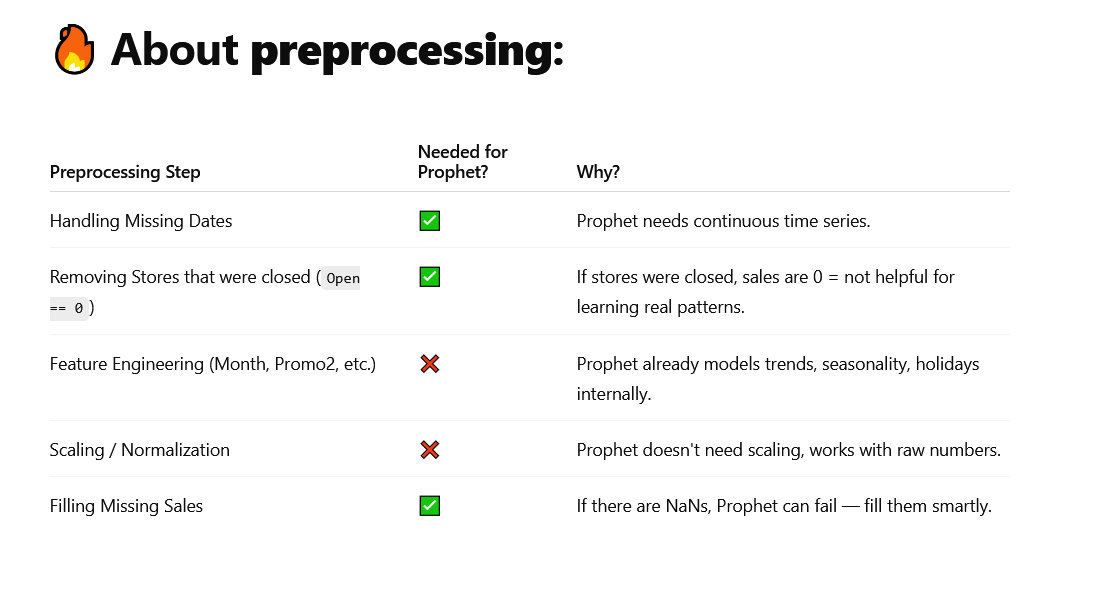

In [44]:
#! pip install prophet

In [45]:
# importing data
df = pd.read_csv("/kaggle/input/rossman-stores-sales/train.csv",  
                    low_memory = False)

# remove closed stores and those with no sales
df = df[(df["Open"] != 0) & (df['Sales'] != 0)]

# sales for the store number 1 (StoreType C)
sales = df[df.Store == 1].loc[:, ['Date', 'Sales']]

sales.head(5)


Date  Sales
0     2015-07-31   5263
1115  2015-07-30   5020
2230  2015-07-29   4782
3345  2015-07-28   5011
4460  2015-07-27   6102

In [46]:
# reverse to the order: from 2013 to 2015
sales = sales.sort_index(ascending = False)

# to datetime64
sales['Date'] = pd.DatetimeIndex(sales['Date'])
sales.dtypes

Date     datetime64[ns]
Sales             int64
dtype: object

In [47]:
# from the prophet documentation every variables should have specific names
sales = sales.rename(columns = {'Date': 'ds',
                                'Sales': 'y'})
sales.head()

ds     y
1014980 2013-01-02  5530
1013865 2013-01-03  4327
1012750 2013-01-04  4486
1011635 2013-01-05  4997
1009405 2013-01-07  7176

In [48]:
# plot daily sales
ax = sales.set_index('ds').plot(figsize = (12, 4), color = c)
ax.set_ylabel('Daily Number of Sales')
ax.set_xlabel('Date')
plt.show()

#### Modeling Holidays

Prophet also allows to model for holidays, and that's what we do here.

The StateHoliday variable in the dataset indicates a state holiday, at which all stores are normally closed. There are also school holidays in the dataset at which ceratin stores are also closing their doors.


In [49]:
# create holidays dataframe
state_dates = df[(df.StateHoliday == 'a') | (df.StateHoliday == 'b') & (df.StateHoliday == 'c')].loc[:, 'Date'].values
school_dates = df[df.SchoolHoliday == 1].loc[:, 'Date'].values

state = pd.DataFrame({'holiday': 'state_holiday',
                      'ds': pd.to_datetime(state_dates)})
school = pd.DataFrame({'holiday': 'school_holiday',
                      'ds': pd.to_datetime(school_dates)})

holidays = pd.concat((state, school))      
holidays.head()

holiday         ds
0  state_holiday 2015-06-04
1  state_holiday 2015-06-04
2  state_holiday 2015-06-04
3  state_holiday 2015-06-04
4  state_holiday 2015-06-04

In [80]:
sales.shape

(781, 2)

In [50]:
# set the uncertainty interval to 95% (the Prophet default is 80%)
my_model = Prophet(interval_width = 0.95, 
                   holidays = holidays)
my_model.fit(sales)

# dataframe that extends into future 6 weeks 
future_dates = my_model.make_future_dataframe(periods = 6*7)

16:56:14 - cmdstanpy - INFO - Chain [1] start processing
16:56:14 - cmdstanpy - INFO - Chain [1] done processing


This line creates a DataFrame of future dates that you want the Prophet model to predict for.

   - periods = 6*7 means 6 weeks into the future.

   - 6 weeks × 7 days per week = 42 days.

So you’re asking Prophet to generate 42 extra future dates after the last date in your training data.

In [84]:
print("future_dates shape: ",future_dates.shape)
print(future_dates.head())

future_dates shape:  (823, 1)
          ds
0 2013-01-02
1 2013-01-03
2 2013-01-04
3 2013-01-05
4 2013-01-07


In [82]:
# last dates exists in the train dataset
Date = pd.DataFrame(df['Date'].unique() ,
                   columns = ['Date'])
Date.head(7)

Date
0  2015-07-31
1  2015-07-30
2  2015-07-29
3  2015-07-28
4  2015-07-27
5  2015-07-26
6  2015-07-25

In [85]:
print("last week to forecast.")
future_dates.tail(7)

last week to forecast.


ds
816 2015-09-05
817 2015-09-06
818 2015-09-07
819 2015-09-08
820 2015-09-09
821 2015-09-10
822 2015-09-11

In [92]:
saless = sales['ds'].to_frame('ds')
saless.head(2)

ds
1014980 2013-01-02
1013865 2013-01-03

In [93]:
# predictions
forecastt = my_model.predict(saless)
forecast = my_model.predict(future_dates)

In [54]:
forecast.head(2)

ds        trend   yhat_lower   yhat_upper  trend_lower  trend_upper  \
0 2013-01-02  5019.369456  4029.559334  7096.459648  5019.369456  5019.369456   
1 2013-01-03  5017.904212  3624.373363  6840.500681  5017.904212  5017.904212   

   additive_terms  additive_terms_lower  additive_terms_upper    holidays  \
0      498.299322            498.299322            498.299322  414.531838   
1      289.784678            289.784678            289.784678  414.531838   

   ...      weekly  weekly_lower  weekly_upper      yearly  yearly_lower  \
0  ... -263.054154   -263.054154   -263.054154  346.821638    346.821638   
1  ... -358.691021   -358.691021   -358.691021  233.943862    233.943862   

   yearly_upper  multiplicative_terms  multiplicative_terms_lower  \
0    346.821638                   0.0                         0.0   
1    233.943862                   0.0                         0.0   

   multiplicative_terms_upper         yhat  
0                         0.0  5517.668778  
1                         0.0  5307.688890  

[2 rows x 28 columns]

In [55]:
# preditions for last week
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

ds         yhat   yhat_lower   yhat_upper
816 2015-09-05  4105.854737  2460.516249  5812.613862
817 2015-09-06  4080.177733  2479.131871  5672.080196
818 2015-09-07  4176.629055  2562.882112  5698.529383
819 2015-09-08  3679.150643  2099.156094  5210.916237
820 2015-09-09  3565.375100  1936.409084  5169.611981
821 2015-09-10  3477.635789  1866.317437  5196.129778
822 2015-09-11  3732.663779  2173.549893  5360.143795



The forecast object here is a new dataframe that includes a column yhat with the forecast, as well as columns for components and uncertainty intervals.


In [56]:
fig1 = my_model.plot(forecast)

- Actual data (black points)

- Forecast (blue line)

- Uncertainty intervals (shaded area)

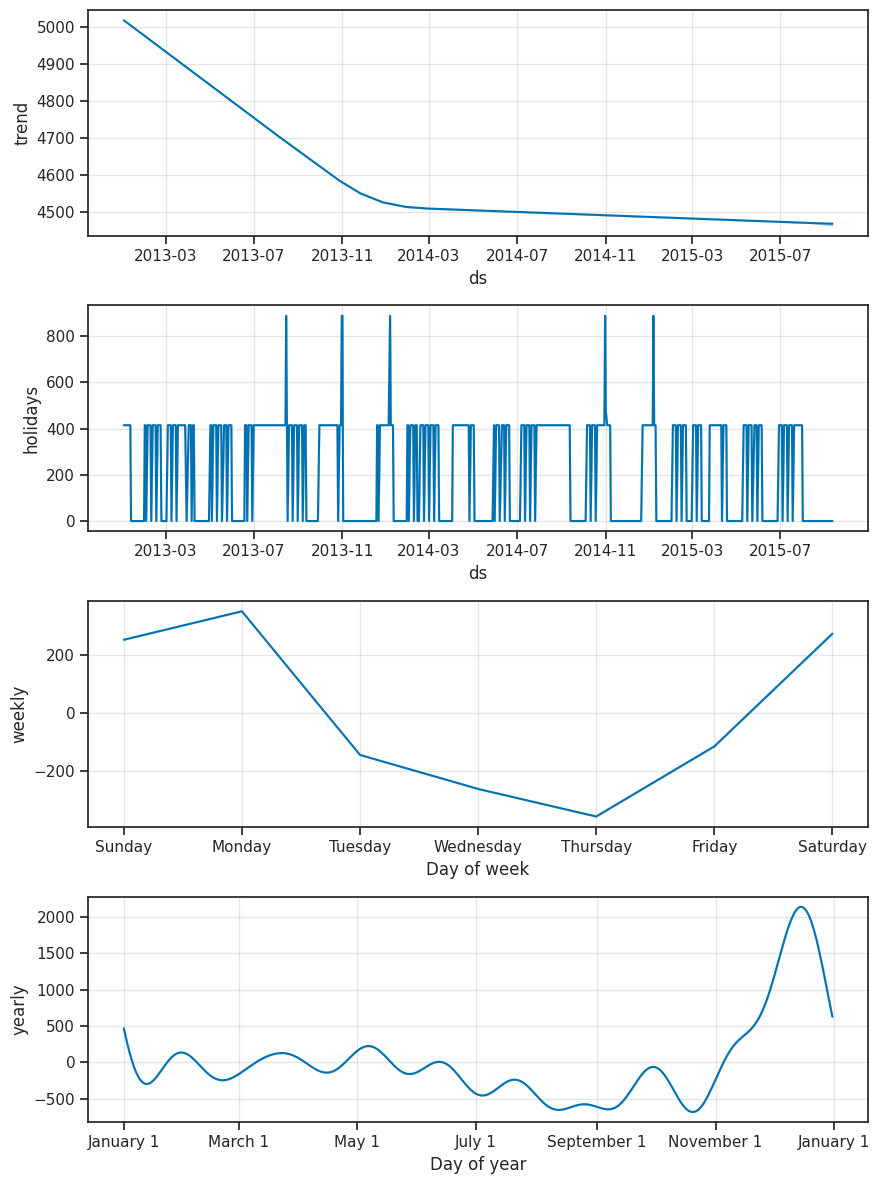

In [57]:
my_model.plot_components(forecast);

The first plot shows that the monthly sales of store number 1 has been linearly decreasing over time and the second shows the holiays gaps included in the model. The third plot highlights the fact that the weekly volume of last week sales peaks towards the Monday of the next week, while the forth plot shows that the most buzy season occurs during the Christmas holidays.

## Evaluation Metrics (Accuracy)

#### - From our train dataset dataframe we created a new dataframe called **'sales'** contains Date and Sales columns only.

#### - Also we created a new Dataframe for holidays dates called **'Holidays'** contains dates of holidays as it is needed by prophet model to detect seasonalities, trends for forecasting.
  
#### - then we passed the dates only existed in **'sales'** dataframe to be forecasted by prophet model we created on a variable called **'forecastt'**.

#### - forecasted sales from our model exists at column called **'yhat'**.

#### - then we compare the sales existed in **'sales'** dataframe with sales existed in **'forecastt'** dataframe.

#### - Metrics used:
   - mean absolute error
   - mean square error
   - root mean square error
   - mean absolute percentage error
   - accuracy

In [94]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# True values
y_true = sales['y'].values
# Predicted values
y_pred = forecastt['yhat'].values

# MAE
mae = mean_absolute_error(y_true, y_pred)
# MSE
mse = mean_squared_error(y_true, y_pred)
# RMSE
rmse = mse ** 0.5
# MAPE (custom)
mape = (abs((y_true - y_pred) / y_true).mean()) * 100

print('MAE:', mae)
print('RMSE:', rmse)
print('MAPE:', mape, '%')  # lower % is better
print('Accuracy:', 100 - mape, '%')  # 100% - MAPE


MAE: 674.1702896702294
RMSE: 832.6118394962039
MAPE: 14.747619716275343 %
Accuracy: 85.25238028372466 %


# 2 - Time Series Analysis and Forecasting using ARIMA

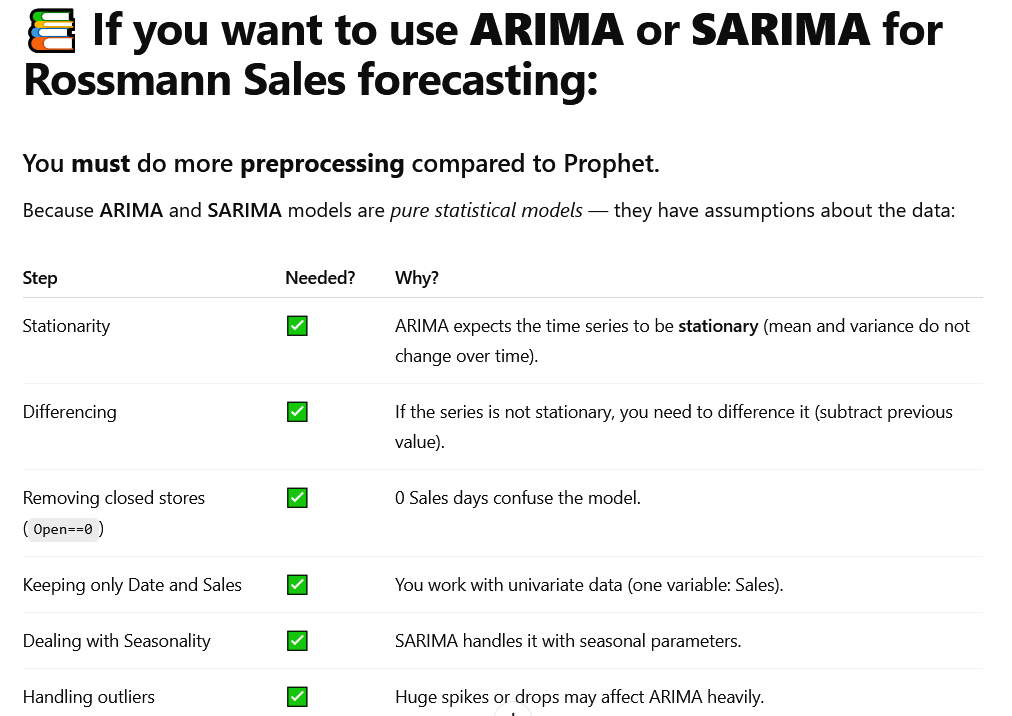
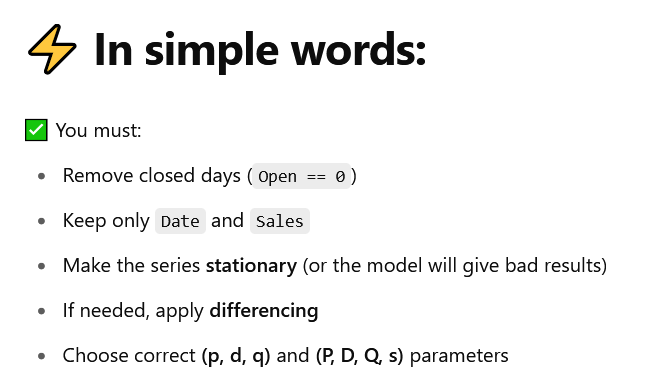

In [4]:
# step1: read data
df_rossman = pd.read_csv("/kaggle/input/rossman-stores-sales/train.csv",
                        parse_dates=True, low_memory=False)

In [33]:
df_rossman_copy = pd.read_csv("/kaggle/input/rossman-stores-sales/train.csv",
                        parse_dates=True, low_memory=False)

In [35]:
df_rossman_copy.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [5]:
df_rossman.head()

Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      2          5  2015-07-31   6064        625     1      1            0   
2      3          5  2015-07-31   8314        821     1      1            0   
3      4          5  2015-07-31  13995       1498     1      1            0   
4      5          5  2015-07-31   4822        559     1      1            0   

   SchoolHoliday  
0              1  
1              1  
2              1  
3              1  
4              1

In [6]:
df_rossman.dtypes

Store             int64
DayOfWeek         int64
Date             object
Sales             int64
Customers         int64
Open              int64
Promo             int64
StateHoliday     object
SchoolHoliday     int64
dtype: object

<Axes: xlabel='Date'>

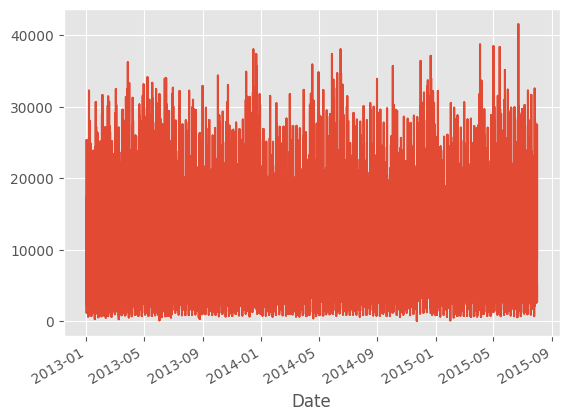

In [7]:
# step2: reverse index order
df_rossman = df_rossman.sort_index(ascending=False)

# step3: filter days where store is close and zero sales.
df_rossman = df_rossman[(df_rossman['Open']==1) & (df_rossman['Sales'] > 0)]

# step4: Keep only Date and sales columns.
df_rossman = df_rossman[['Date','Sales']]

# step5 change datetime datatype 
df_rossman['Date'] = pd.DatetimeIndex(df_rossman['Date'])


# step6: set date as index.
df_rossman.set_index('Date', inplace=True)

# step7: plot to see stationery
df_rossman['Sales'].plot()

In [8]:
# Step 8: Check stationarity (using ADF test)
from statsmodels.tsa.stattools import adfuller
sales_sample = df_rossman['Sales'].iloc[:5000]  # use first 5000 rows only

result = adfuller(sales_sample)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
# If p-value > 0.05 → NOT stationary → apply differencing

ADF Statistic: -4.06672288137239
p-value: 0.0010987323574170042


In [39]:
px.box(df_rossman,
           y = "Sales")

In [43]:
# create holidays dataframe
state_dates = df_rossman_copy[(df_rossman_copy.StateHoliday == 'a') | (df_rossman_copy.StateHoliday == 'b') & (df_rossman_copy.StateHoliday == 'c')].loc[:, 'Date'].values
school_dates = df_rossman_copy[df_rossman_copy.SchoolHoliday == 1].loc[:, 'Date'].values

state = pd.DataFrame({'holiday': 'state_holiday',
                      'ds': pd.to_datetime(state_dates)})
school = pd.DataFrame({'holiday': 'school_holiday',
                      'ds': pd.to_datetime(school_dates)})

holidays = pd.concat((state, school))  

# Ensure both 'ds' (from holidays) and 'Date' (from main dataframe) are datetime objects
holidays['ds'] = pd.to_datetime(holidays['ds'])

holidays.head(2)

holiday         ds
0  state_holiday 2015-06-04
1  state_holiday 2015-06-04

In [68]:
# Create the binary indicator for whether the date is a holiday (1 if it's a holiday, 0 if it's not)
df_rossman['is_holiday'] = df_rossman.index.isin(holidays['ds']).astype(int)

In [76]:
df_rossman.head()

Sales  is_holiday
Date                         
2013-01-01   5961           1
2013-01-01   4491           1
2013-01-01   5035           1
2013-01-01  10765           1
2013-01-01   3375           1

In [73]:
df_rossman[df_rossman['is_holiday']==0].head()

Sales  is_holiday
Date                         
2013-01-12   4497           0
2013-01-12  18841           0
2013-01-12   5285           0
2013-01-12  10212           0
2013-01-12   3709           0

In [9]:
# 1- Split your data into train and test
train_size = int(len(df_rossman) * 0.8)  # 80% train, 20% test
train = df_rossman[:train_size]
test = df_rossman[train_size:]

In [10]:
# 2- Fit the model on train only
from statsmodels.tsa.arima.model import ARIMA

# Example: ARIMA(p,d,q)
model = ARIMA(train['Sales'], order=(1, 0, 0))
model_fit = model.fit()


#### 📚 How to choose ARIMA p and q using ACF and PACF

First:
Remember ARIMA(p, d, q):

   - p = lag order (related to PACF)

   - d = differencing (you have d=0 because data is stationary)

   - q = moving average order (related to ACF)

Steps:
1. Plot ACF and PACF graphs

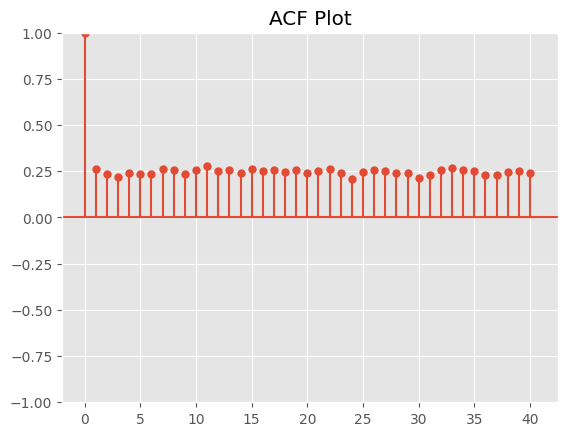

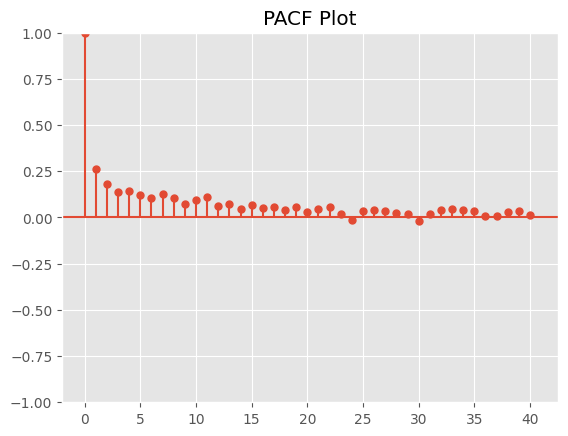

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Plot ACF
plot_acf(df_rossman['Sales'], lags=40)
plt.title('ACF Plot')
plt.show()

# Plot PACF
plot_pacf(df_rossman['Sales'], lags=40)
plt.title('PACF Plot')
plt.show()

📊 ACF (top plot)

   - It does not drop quickly — it stays high across many lags.

   - That usually hints that q is not small — or that an AR part (p) is more important than an MA part (q).

📈 PACF (bottom plot)

   - Huge spike at lag 1 ✅

   - Then drops after lag 1 (small values after that).

This tells us:

   - p = 1

➡️ Because PACF cuts off after lag 1.

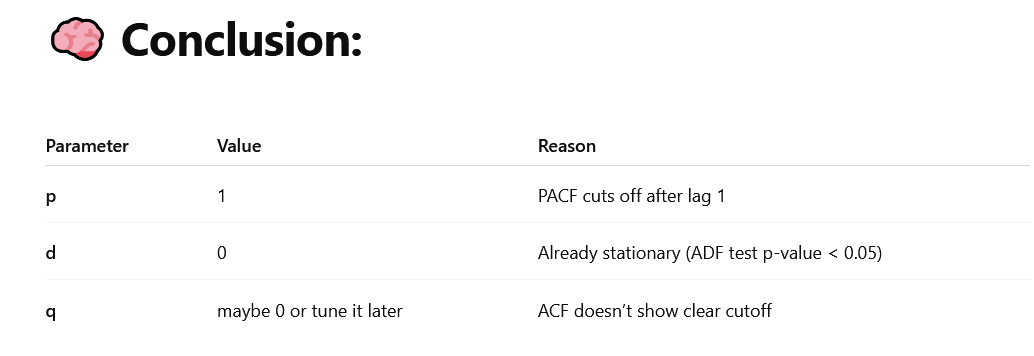

In [12]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:               675470
Model:                 ARIMA(1, 0, 0)   Log Likelihood            -6366138.935
Date:                Sat, 26 Apr 2025   AIC                       12732283.870
Time:                        21:05:46   BIC                       12732318.139
Sample:                             0   HQIC                      12732293.451
                             - 675470                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       6915.2619      6.279   1101.391      0.000    6902.956    6927.568
ar.L1          0.2686      0.001    275.740      0.000       0.267       0.270
sigma2       8.99e+06   1.01e+04    892.973      0.0

In [13]:
# 3- Forecast the future values (for the size of the test set)
# Forecast same number of steps as length of test set
forecast = model_fit.forecast(steps=len(test))

## Evaluation Metrcis (Accuracy)

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np

# RMSE
rmse = np.sqrt(mean_squared_error(test['Sales'], forecast))
print(f'RMSE: {rmse}')

# MAPE
mape = mean_absolute_percentage_error(test['Sales'], forecast)
print(f'MAPE: {mape * 100:.2f}%')

#Accuracy
print('Accuracy:', 100 - mape*100, '%')  # 100% - MAPE

RMSE: 3069.3578564951713
MAPE: 36.76%
Accuracy: 63.23789580938461 %


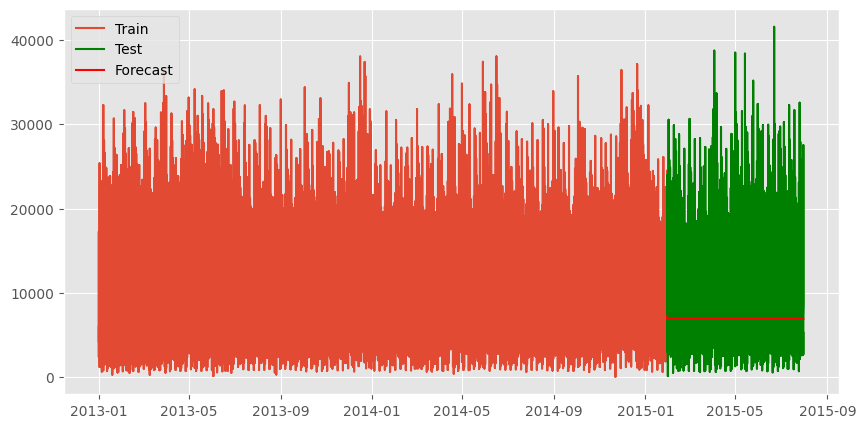

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(train.index, train['Sales'], label='Train')
plt.plot(test.index, test['Sales'], label='Test', color='green')
plt.plot(test.index, forecast, label='Forecast', color='red')
plt.legend()
plt.show()


## Grid Search

In [16]:
import warnings
import itertools
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

warnings.filterwarnings("ignore")

# Define the p, d, q ranges
p = d = q = range(0, 3)  # trying values 0,1,2
pdq = list(itertools.product(p, d, q))  # all possible combinations

# Store the results
best_score, best_cfg = float("inf"), None

for param in pdq:
    try:
        model = ARIMA(train, order=param)
        model_fit = model.fit()
        pred = model_fit.forecast(steps=len(test))
        error = mean_squared_error(test, pred)
        if error < best_score:
            best_score, best_cfg = error, param
        print(f'ARIMA{param} MSE={error:.3f}')
    except:
        continue

print(f'\nBest ARIMA{best_cfg} MSE={best_score:.3f}')


ARIMA(0, 0, 0) MSE=9420949.685
ARIMA(0, 0, 1) MSE=9420955.322
ARIMA(0, 0, 2) MSE=9420957.879
ARIMA(0, 1, 0) MSE=10672886.831
ARIMA(0, 1, 1) MSE=12029587.566
ARIMA(0, 1, 2) MSE=12012614.542
ARIMA(0, 2, 0) MSE=750516224382410.375
ARIMA(0, 2, 1) MSE=17031918.380
ARIMA(0, 2, 2) MSE=3038944631.235
ARIMA(1, 0, 0) MSE=9420957.651
ARIMA(1, 0, 1) MSE=9613607.448
ARIMA(1, 0, 2) MSE=11326054.395
ARIMA(1, 1, 0) MSE=10889734.543
ARIMA(1, 1, 1) MSE=12012582.355
ARIMA(1, 1, 2) MSE=12032813.454
ARIMA(1, 2, 0) MSE=1030634931927010.750
ARIMA(1, 2, 1) MSE=14369255.468
ARIMA(1, 2, 2) MSE=70140782.874
ARIMA(2, 0, 0) MSE=9420959.837
ARIMA(2, 0, 1) MSE=11681730.066
ARIMA(2, 0, 2) MSE=9414839.925
ARIMA(2, 1, 0) MSE=10531108.930
ARIMA(2, 1, 1) MSE=12023869.758
ARIMA(2, 1, 2) MSE=12085555.524
ARIMA(2, 2, 0) MSE=65874423563273.680
ARIMA(2, 2, 1) MSE=13108081.260

Best ARIMA(2, 0, 2) MSE=9414839.925


From what you showed:

   - Best MSE so far = 9,420,949 with ARIMA(0,0,0) (but that’s very high).

   - Also ARIMA(1,0,1) gives 9,613,607, very close.

→ But generally all results are pretty bad so far (MSE is huge).

🧠 Why?

Because Rossmann Sales is a complex time series:

   - It has trend (going up/down)

   - It has seasonality (weekly, monthly patterns)

   - It is influenced by promotions, holidays, competition...

Simple ARIMA (with (p,d,q)) without exogenous variables (external features) will struggle.
You need models that can handle seasonality better like:

   - SARIMA (Seasonal ARIMA)

   - Prophet

   - XGBoost/LightGBM on features

   - LSTM / RNN (deep learning)

# 3- Time Series Analysis & Forecasting using SARIMA

#### SARIMA stands for:

SARIMA(p, d, q) x (P, D, Q, s)

Where:

   - (p, d, q) = normal ARIMA parts (Auto-regression, Differencing, Moving average)

   - (P, D, Q, s) = Seasonal parts (same idea, but across a season, like every 7 days or 365 days)

   - s = length of the season (e.g., 7 for weekly seasonality)

In [78]:
weekly_sales = df_rossman['Sales'].resample('W-Mon').sum()

In [79]:
# Create weekly holiday indicator (1 if any day in the week is a holiday, 0 otherwise)
weekly_holiday = df_rossman.resample('W-Mon').apply(lambda x: x['is_holiday'].max())

<Axes: title={'center': 'Weekly Aggregated Sales'}, xlabel='Date'>

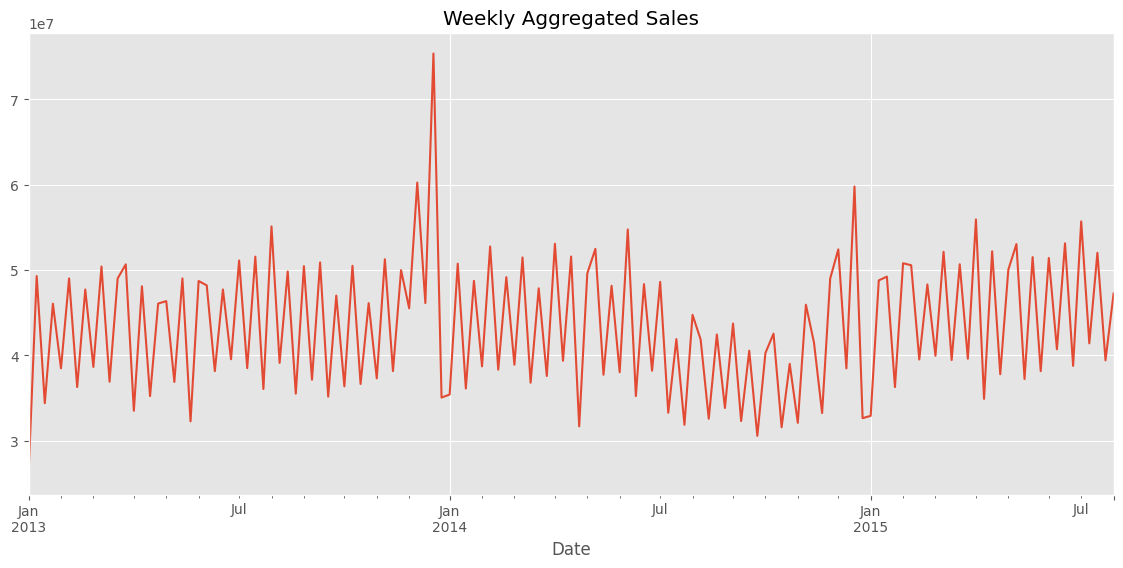

In [18]:
weekly_sales.plot(figsize=(14,6), title='Weekly Aggregated Sales')

In [80]:
# Train/Test split
train = weekly_sales[:'2014-12-31']
test = weekly_sales['2015-01-01':]

# Make sure the exogenous variables are aligned with the weekly sales data
train_holiday = weekly_holiday[:'2014-12-31']  # Align with training period
test_holiday = weekly_holiday['2015-01-01':]  # Align with test period

In [ ]:
# basic SARIMA fitting
from statsmodels.tsa.statespace.sarimax import SARIMAX

# SARIMA or ARIMA modeling
model = SARIMAX(train, order=(1,1,1), seasonal_order=(0,1,1,52))  # 52 weeks in year
model_fit = model.fit(disp=False)

preds = model_fit.predict(start=len(train), end=len(train)+len(test)-1)

In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

rmse = np.sqrt(mean_squared_error(test, preds))
print(f'RMSE: {rmse}')

mape = np.mean(np.abs((test - preds) / test)) * 100
print(f'MAPE: {mape:.2f}%')

accuracy = 100 - mape
print(f'Accuracy: {accuracy:.2f}%')

RMSE: 10528563.832442906
MAPE: 22.17%
Accuracy: 77.83%


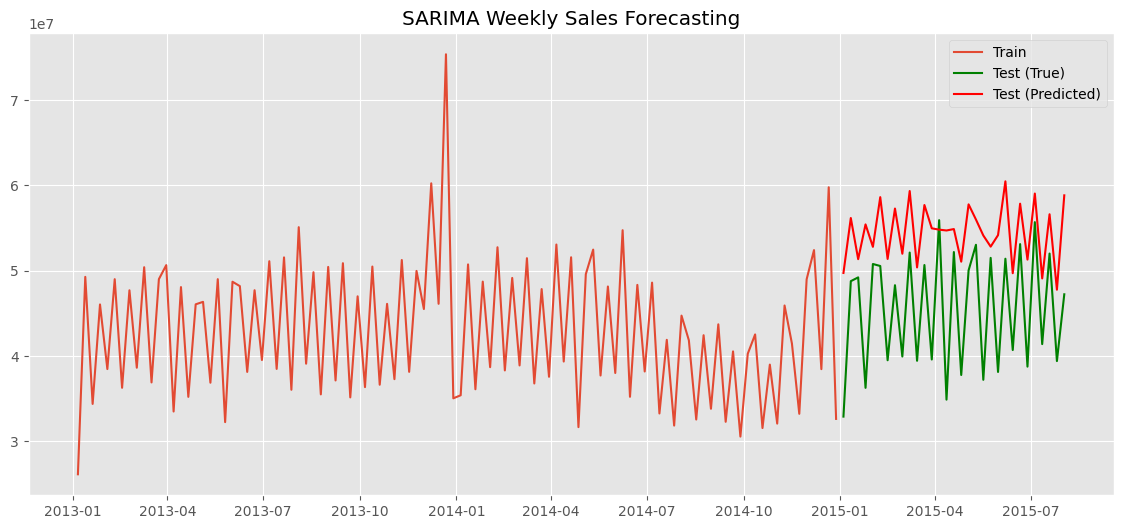

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test (True)', color='green')
plt.plot(test.index, preds, label='Test (Predicted)', color='red')
plt.title('SARIMA Weekly Sales Forecasting')
plt.legend()
plt.show()


In [26]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 23.1 MB/s eta 0:00:00a 0:00:01


In [81]:
import pmdarima as pm

# Fit the auto_arima model
auto_model = pm.auto_arima(train, 
                           seasonal=True,
                           exogeneous = train_holiday ,
                           m=52,  # 52 weeks in a year
                           stepwise=True,  # Search for the best model step by step
                           trace=True)  # Print progress

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[52] intercept   : AIC=3527.109, Time=8.42 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=3535.748, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=3533.654, Time=1.19 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=3525.827, Time=0.58 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=3954.929, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[52] intercept   : AIC=3536.762, Time=0.04 sec
 ARIMA(0,0,1)(1,0,1)[52] intercept   : AIC=3527.812, Time=1.04 sec
 ARIMA(0,0,1)(0,0,2)[52] intercept   : AIC=3526.625, Time=2.31 sec
 ARIMA(0,0,1)(1,0,0)[52] intercept   : AIC=3538.731, Time=1.03 sec
 ARIMA(0,0,1)(1,0,2)[52] intercept   : AIC=3528.601, Time=4.00 sec
 ARIMA(0,0,0)(0,0,1)[52] intercept   : AIC=3525.789, Time=0.43 sec
 ARIMA(0,0,0)(1,0,1)[52] intercept   : AIC=3527.787, Time=0.74 sec
 ARIMA(0,0,0)(0,0,2)[52] intercept   : AIC=3526.936, Time=1.94 sec
 ARIMA(0,0,0)(1,0,0)[52] intercept   : AIC=3537.622, Time=0.41 sec
 ARIMA(0,0,0)(1,0,2

In [82]:
# Make predictions
preds_auto_arima = auto_model.predict(n_periods=len(test))

In [83]:
# Evaluate predictions
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(test, preds_auto_arima)
print(f"Mean Squared Error: {mse}")

mape = np.mean(np.abs((test - preds_auto_arima) / test)) * 100
print(f'MAPE: {mape:.2f}%')

accuracy = 100 - mape
print(f'Accuracy: {accuracy:.2f}%')

Mean Squared Error: 17641129373034.617
MAPE: 7.51%
Accuracy: 92.49%


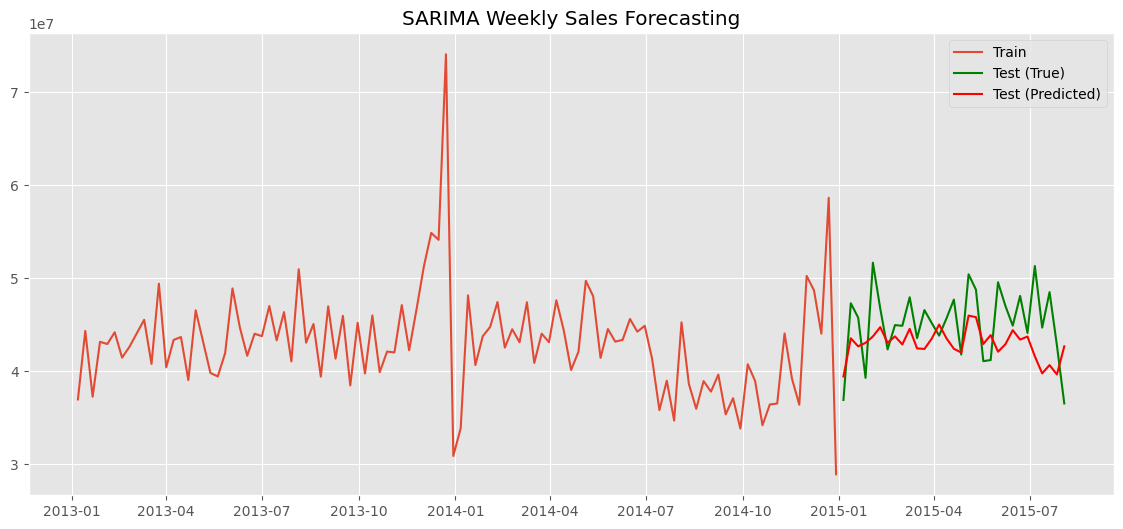

In [84]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test (True)', color='green')
plt.plot(test.index, preds_auto_arima, label='Test (Predicted)', color='red')
plt.title('SARIMA Weekly Sales Forecasting')
plt.legend()
plt.show()


# Conclusion of Time Series forecasting

During this part, we discussed time series analysis with .seasonal_decompose(), ACF and PCF plots and fitted forecasting model using a new procedure by Facebook Prophet.

We can now present main advantages and drawbacks of time series forecasting:
Advantages

   - A powerful tool for the time series forecasting as it accounts for time dependencies, seasonalities and holidays (Prophet: manually).
   - Easily implemented with R auto.arima() from forecast package, which runs a complex grid search and sophisticated algorithm behind the scene.

Drawbacks

   - Doesn't catch interactions between external features, which could improve the forecasting power of a model. In our case, these variables are Promo and CompetitionOpen.
   - Even though Prophet offers an automated solution for ARIMA, this methodology is under development and not completely stable.
   - Fitting seasonal ARIMA model needs 4 to 5 whole seasons in the dataset, which can be the biggest drawback for new companies.
   - Seasonal ARIMA in Python has 7 hyper parameters which can be tuned only manually affecting significantly the speed of the forecasting process.



---------------------------------------------------------------------------------------------------

#### 1. In basic Prophet:

Prophet is built to forecast just from the date ("ds") and the target variable ("y").

✅ Meaning:

   - Prophet assumes that time itself carries patterns:

       - Seasonality (like weekends, holidays, months).

       - Trends (like general increase or decrease over time).

       - Yearly patterns, weekly patterns, etc.

Without needing extra features (at first).

So even if you pass only dates, Prophet can forecast based on:

   - Trend (up or down over time)

   - Seasonality (recurring patterns)

   - Holidays (if you add them)

➡️ That’s why it needs just the dates to forecast at first!

#### 2. What about other features (like store type, promo, competition)?

In real-life, things like promotions, store type, holidays affect sales a lot.

👉 Prophet allows you to add them too, but you need to add them as regressors manually.

How? You use:

> my_model.add_regressor('feature_name')

for each extra feature you want to consider.

Then when you call predict, you must also provide values for these features in the future dates.

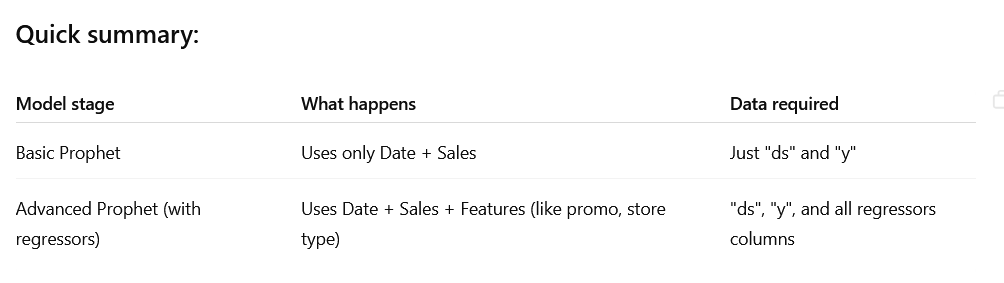

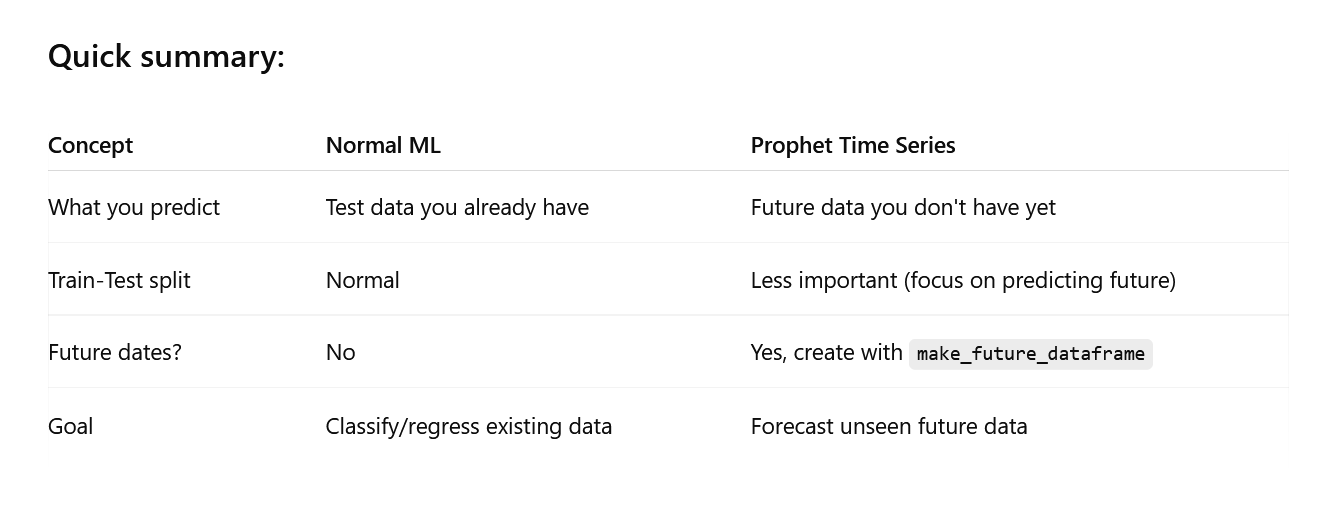